### Importing Libraries

In [1]:
import sys
import os

# Add the 'training' directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

from pprint import pprint
from copy import deepcopy
from functools import partial
from collections import Counter
import holidays

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# Feature Selectionb
from utils.boruta_py import BorutaPy
import tsfresh as tsf

# Sklearn
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor

# Hyper-parameter tunning
from hyperopt import fmin, hp, tpe, STATUS_OK
from hyperopt.fmin import generate_trials_to_calculate
from hyperopt.pyll.base import scope

# Modeling
from modeling.model import Model

# S3 utils
from utils.s3_utils import load_from_s3, write_to_s3

# Config
from config.config import BUCKET

import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging

logger = logging.getLogger(__name__)

In [4]:
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

# Explanatory Data Analysis

### Load Datasets
- The **energy file** records Spain’s hourly electricity prices, in Euros per mega watt hour (€/MWh); electricity generation by type of origin (coal, gas, wind power, etc.) in MWh; and energy demand (“load”) in MWh.
- The **weather file** offers the hourly records of five major Spanish cities.
- We will aim to forecast **one lag ahead**

In [5]:
# Energy Dataset
energy_df: pd.DataFrame = load_from_s3(path=f"{BUCKET}/datasets/energy_dataset.csv")
# energy_df = pd.read_csv(energy_path, header=0, parse_dates=["time"])

# Weather Features
weather_df: pd.DataFrame = load_from_s3(path=f"{BUCKET}/datasets/weather_features.csv")
# weather_df = pd.read_csv(weather_path, header=0, parse_dates=["dt_iso"])

### Energy Data - Data Analysis & Data Cleaning

In [6]:
# Prepare idx
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, infer_datetime_format=True).dt.tz_localize(None)
energy_df.set_index('time', inplace=True)

#### Basic Characteristics

In [7]:
energy_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [8]:
energy_df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [9]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil coal-derived gas           35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation fossil oil shale                  35046 non-null  float64
 7   generation fossil peat                       35046 non-null  float64
 8   generation geothermal                        35046 non-null  float64
 9   generation hydro pumped storage aggre

#### Missing Values
- We observe two empty feature columns. On the right-hand side, we notice a few gaps in individual rows of the other columns.

<Axes: >

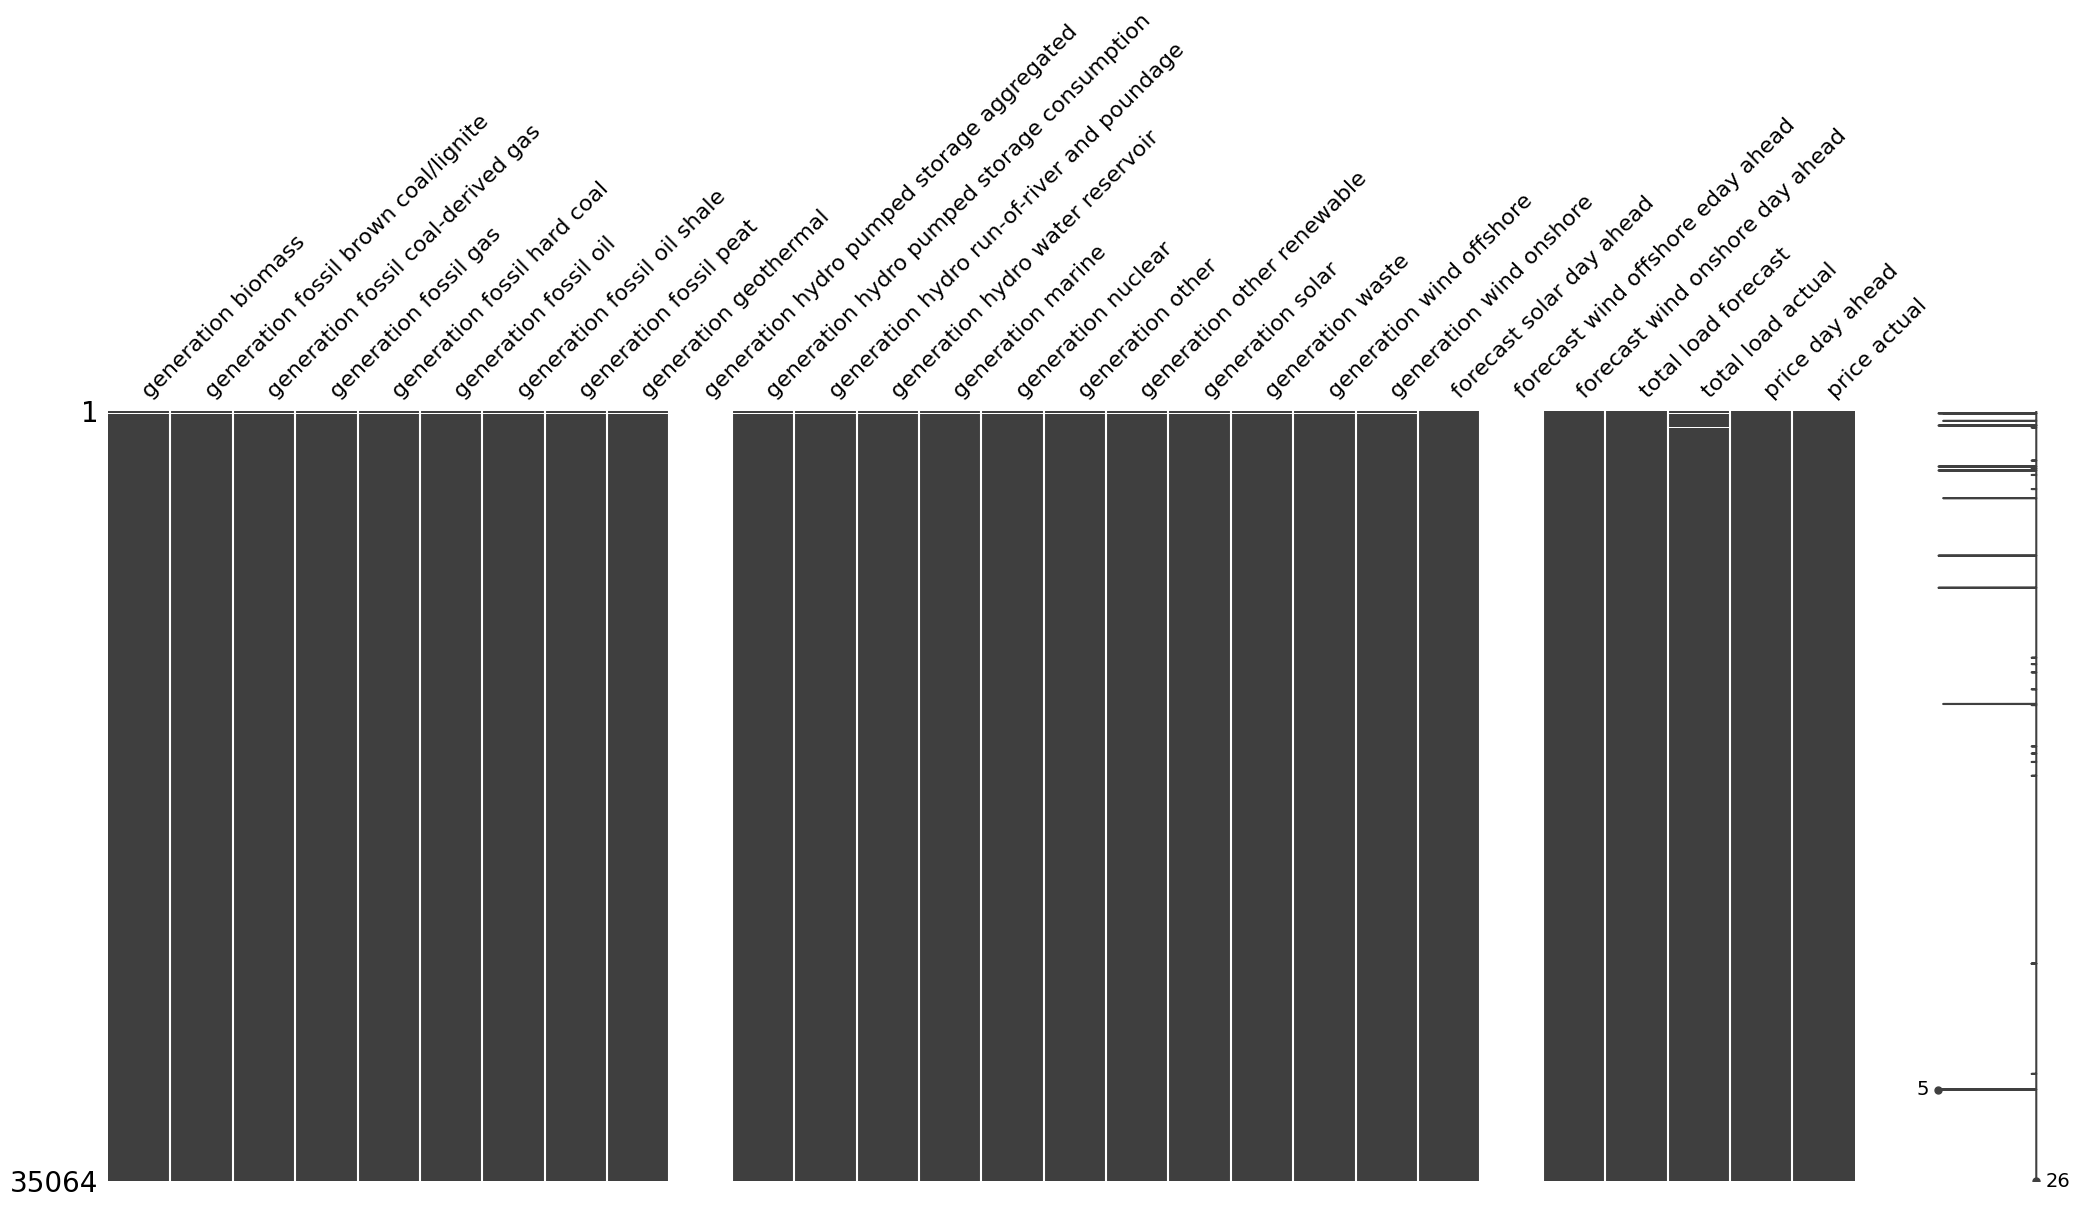

In [10]:
msno.matrix(energy_df)

In [11]:
# Drop columns with all null values
energy_df.dropna(axis=1, how="all", inplace=True)

In [12]:
# Interpolate missing values from remaining rows
energy_df = energy_df.interpolate(method ="bfill")

In [13]:
# Drop columns with all values equal to 0
energy_df = energy_df.loc[:, (energy_df!=0).any(axis=0)]

In [14]:
# Drop "forecast" columns
energy_df = energy_df.drop(energy_df.filter(regex="forecast").columns, axis=1, errors="ignore")

#### Rename columns
- The original column names contain some spaces and special characters.

In [15]:
rename_dict = {
    'generation biomass': 'gen_bio', 
    'generation fossil brown coal/lignite': 'gen_lig', 
    'generation fossil coal-derived gas': 'gen_coal_gas', 
    'generation fossil gas': 'gen_gas', 
    'generation fossil hard coal': 'gen_coal', 
    'generation fossil oil': 'gen_oil', 
    'generation fossil oil shale': 'gen_oil_shale', 
    'generation fossil peat': 'gen_peat', 
    'generation geothermal': 'gen_geo', 
    'generation hydro pumped storage consumption': 'gen_hyd_pump', 
    'generation hydro run-of-river and poundage': 'gen_hyd_river', 
    'generation hydro water reservoir': 'gen_hyd_res', 
    'generation marine': 'gen_mar', 
    'generation nuclear': 'gen_nuc', 
    'generation other': 'gen_other', 
    'generation other renewable': 'gen_oth_renew', 
    'generation solar': 'gen_sol', 
    'generation waste': 'gen_waste', 
    'generation wind offshore': 'gen_wind_off', 
    'generation wind onshore': 'gen_wind_on', 
    'total load actual': 'load_actual', 
    'price day ahead': 'price_dayahead', 
    'price actual': 'price'
}

In [16]:
energy_df.rename(columns=rename_dict, inplace=True)

#### Duplicates

In [17]:
# Show duplicated idxs
energy_df.loc[energy_df.index.duplicated()]

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_sol,gen_waste,gen_wind_on,load_actual,price_dayahead,price
time,,,,,,,,,,,,,,,,,


In [18]:
# Remove duplicated rows
energy_df = energy_df.loc[~energy_df.index.duplicated()]

In [19]:
# Remove duplicated columns
energy_df = energy_df.loc[:, ~energy_df.columns.duplicated(keep='first')]

#### Extreme values

In [20]:
# Calculate the absolute z_scores
z_scores = np.abs(st.zscore(energy_df))

In [21]:
z_scores.head()

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_sol,gen_waste,gen_wind_on,load_actual,price_dayahead,price
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,0.743689,0.335849,0.353719,0.287714,2.595973,0.488934,0.196659,0.384985,0.990771,0.85118,0.897527,0.823748,1.461960,0.284168,0.724125,0.015436,0.529854
2015-01-01 00:00:00,0.767123,0.338669,0.193825,0.254074,2.672133,0.560873,0.091844,0.516297,0.990771,0.85118,1.039605,0.823152,1.481872,0.132306,0.943288,0.121375,0.495356
2015-01-01 01:00:00,0.755406,0.352769,0.347814,0.165388,2.691173,0.868825,0.002003,0.672673,0.994341,0.85118,0.897527,0.823152,1.461960,0.001197,1.303389,0.174047,0.464379
2015-01-01 02:00:00,0.638234,0.547346,0.594469,0.063972,2.634053,1.296675,0.057891,0.995232,0.993151,0.85118,0.755450,0.823152,1.561524,0.070593,1.619788,0.520179,0.101098
2015-01-01 03:00:00,0.521063,0.736283,0.678050,0.212292,2.710213,1.704332,0.047909,1.027379,0.991961,0.85118,0.826489,0.827914,1.601349,0.164885,1.843103,0.784225,0.129825


In [22]:
# Remove values where z_score is over 2.5 stdev
for col in energy_df.columns:
    energy_df.loc[z_scores[col] > 2.5] = np.nan

In [23]:
# Replace outliers with mean/median values for that column
means_dict = {col: energy_df[col].median() for col in energy_df.columns}

In [24]:
energy_df.fillna(value=means_dict, inplace=True)

In [25]:
energy_df.describe()

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_sol,gen_waste,gen_wind_on,load_actual,price_dayahead,price
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.675907,487.955168,5478.795460,4462.490303,300.311345,294.619581,931.991016,2395.465235,6374.451660,60.286533,86.595311,1353.226529,275.838838,5056.763204,28775.219313,51.487083,58.895475
std,78.436543,316.814664,1666.737831,1714.721215,45.580962,505.492396,350.558603,1527.552195,732.537356,17.188887,12.516925,1587.607736,41.586527,2627.024964,4010.158313,11.136598,11.288587
min,175.000000,0.000000,2317.000000,576.000000,168.000000,0.000000,285.000000,151.000000,4169.000000,10.000000,51.000000,2.000000,144.000000,234.000000,18179.000000,13.460000,22.390000
25%,343.000000,226.000000,4396.000000,3229.750000,275.000000,0.000000,670.000000,1239.000000,5984.000000,55.000000,77.000000,138.000000,258.000000,3221.750000,25743.750000,45.190000,52.720000
50%,367.000000,558.000000,5047.000000,4659.000000,301.000000,54.000000,872.000000,2060.000000,6680.000000,57.000000,88.000000,648.000000,282.000000,4645.000000,28918.000000,51.490000,58.650000
75%,398.250000,684.000000,6004.250000,5635.000000,323.000000,351.000000,1145.000000,3204.000000,6979.000000,65.000000,96.000000,2149.000000,306.000000,6380.000000,31437.000000,59.000000,66.050000
max,592.000000,999.000000,11126.000000,8359.000000,429.000000,2456.000000,1973.000000,7193.000000,7117.000000,106.000000,119.000000,5630.000000,357.000000,13498.000000,40122.000000,86.400000,93.230000


### Target Anlysis
- A lineplot of the hourly prices shows that the curve that does not appear to follow a stable long-term trend or a single seasonality pattern, but fluctuates around a mean price of €60. 
- Since we deal with hourly prices, there might also be seasonalities related to **hours**, **weekdays** & **months**

<Axes: xlabel='time', ylabel='price'>

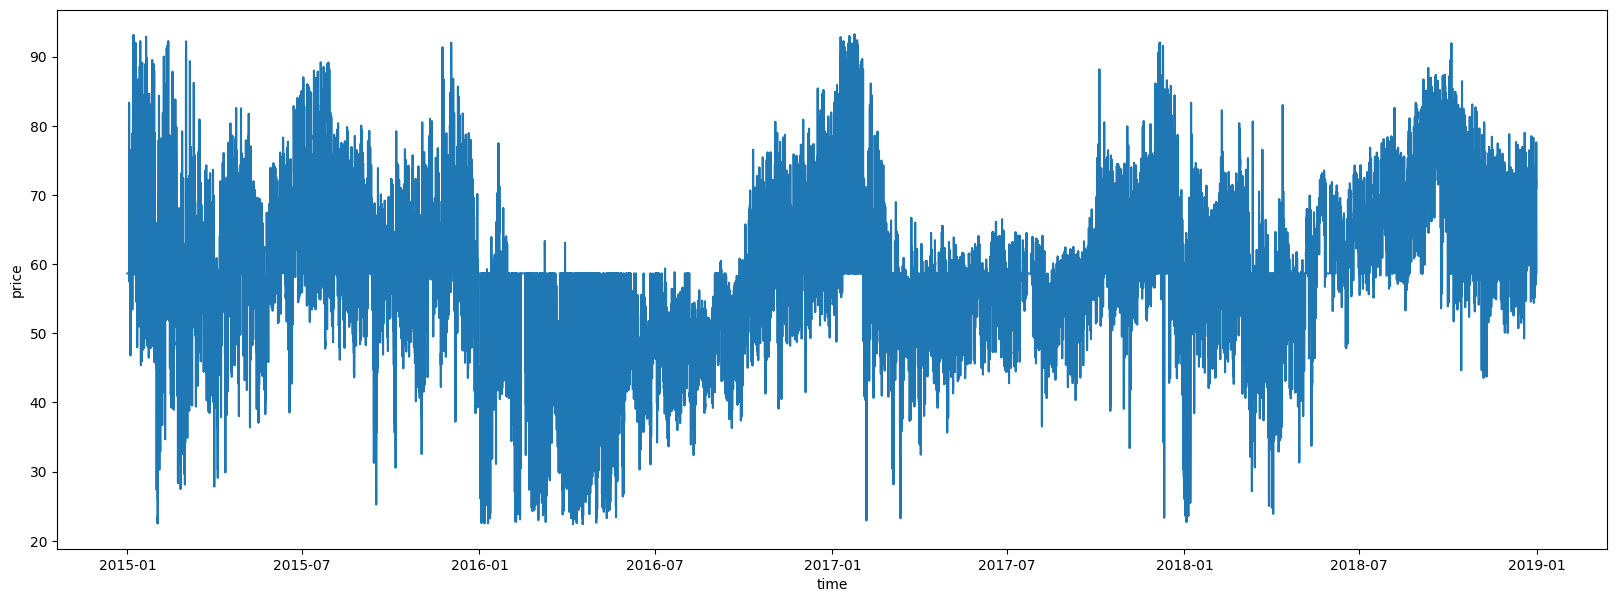

In [26]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(
    x="time", 
    y="price", 
    data=energy_df, 
    palette="coolwarm"
)

#### Auto-Correlations & Partial Auto-Correlations
- Both plots show statistically significant AC values and PAC values
- This indicates that the data is autocorrelated, which could imply that there are some seasonality effects.

<Figure size 2000x700 with 0 Axes>

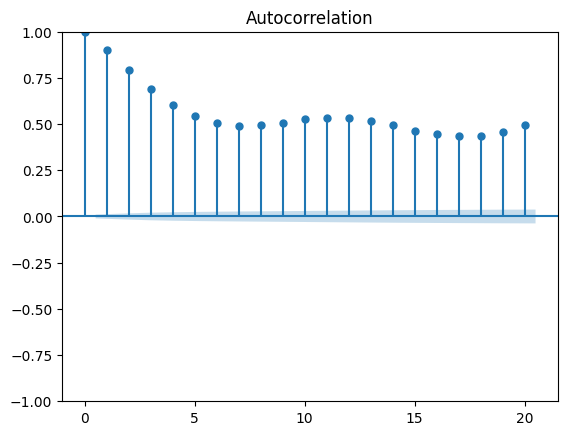

In [27]:
plt.figure(100, figsize=(20, 7))
plot_acf(energy_df['price'], lags=20, alpha=0.05)
plt.show()

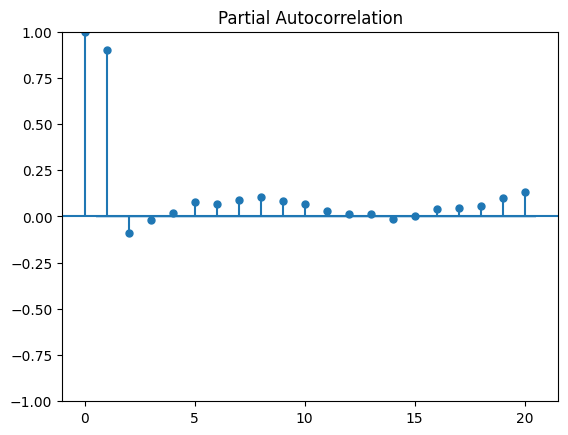

In [28]:
plot_pacf(energy_df['price'], lags=20, alpha=0.05)
plt.show()

#### Seasonal decomposition
- Decomposing the time series with both **weekly** and **monthly** frequencies portray a decisive seasonality component for the time series.

In [29]:
# Define data to plot
last_year = energy_df.loc[energy_df.index > '2018', 'price']

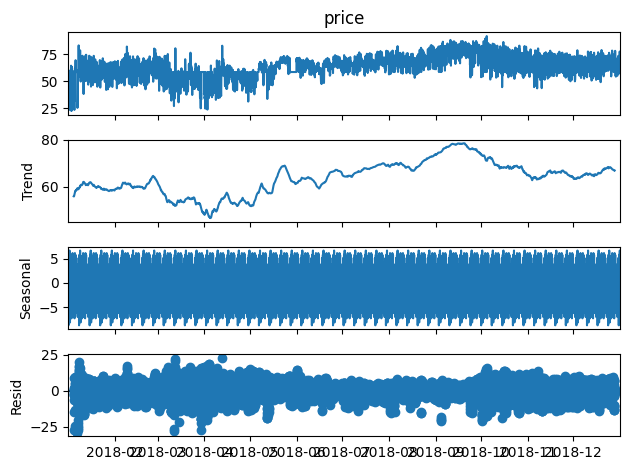

In [30]:
# Plot Weekly frequency
decomp = seasonal_decompose(last_year, period=24*7)

decomp.plot()
plt.show()

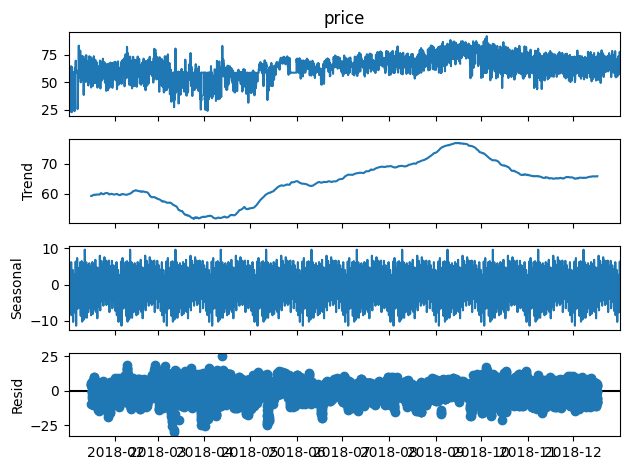

In [31]:
# Plot Monthly frequency
decomp = seasonal_decompose(last_year, period=24*30)

decomp.plot()
plt.show()

### Weather Data - Data Analysis & Data Cleaning

In [32]:
# Prepare idx
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True, infer_datetime_format=True).dt.tz_localize(None)
weather_df.set_index('dt_iso', inplace=True)

#### Basic Characteristics

In [33]:
weather_df.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [34]:
weather_df.city_name.unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [35]:
weather_df.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [36]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   city_name            178396 non-null  object 
 1   temp                 178396 non-null  float64
 2   temp_min             178396 non-null  float64
 3   temp_max             178396 non-null  float64
 4   pressure             178396 non-null  int64  
 5   humidity             178396 non-null  int64  
 6   wind_speed           178396 non-null  int64  
 7   wind_deg             178396 non-null  int64  
 8   rain_1h              178396 non-null  float64
 9   rain_3h              178396 non-null  float64
 10  snow_3h              178396 non-null  float64
 11  clouds_all           178396 non-null  int64  
 12  weather_id           178396 non-null  int64  
 13  weather_main         178396 non-null  object 
 14  weather_description  178396 non-nu

#### Missing Values
- No missing values were found

<Axes: >

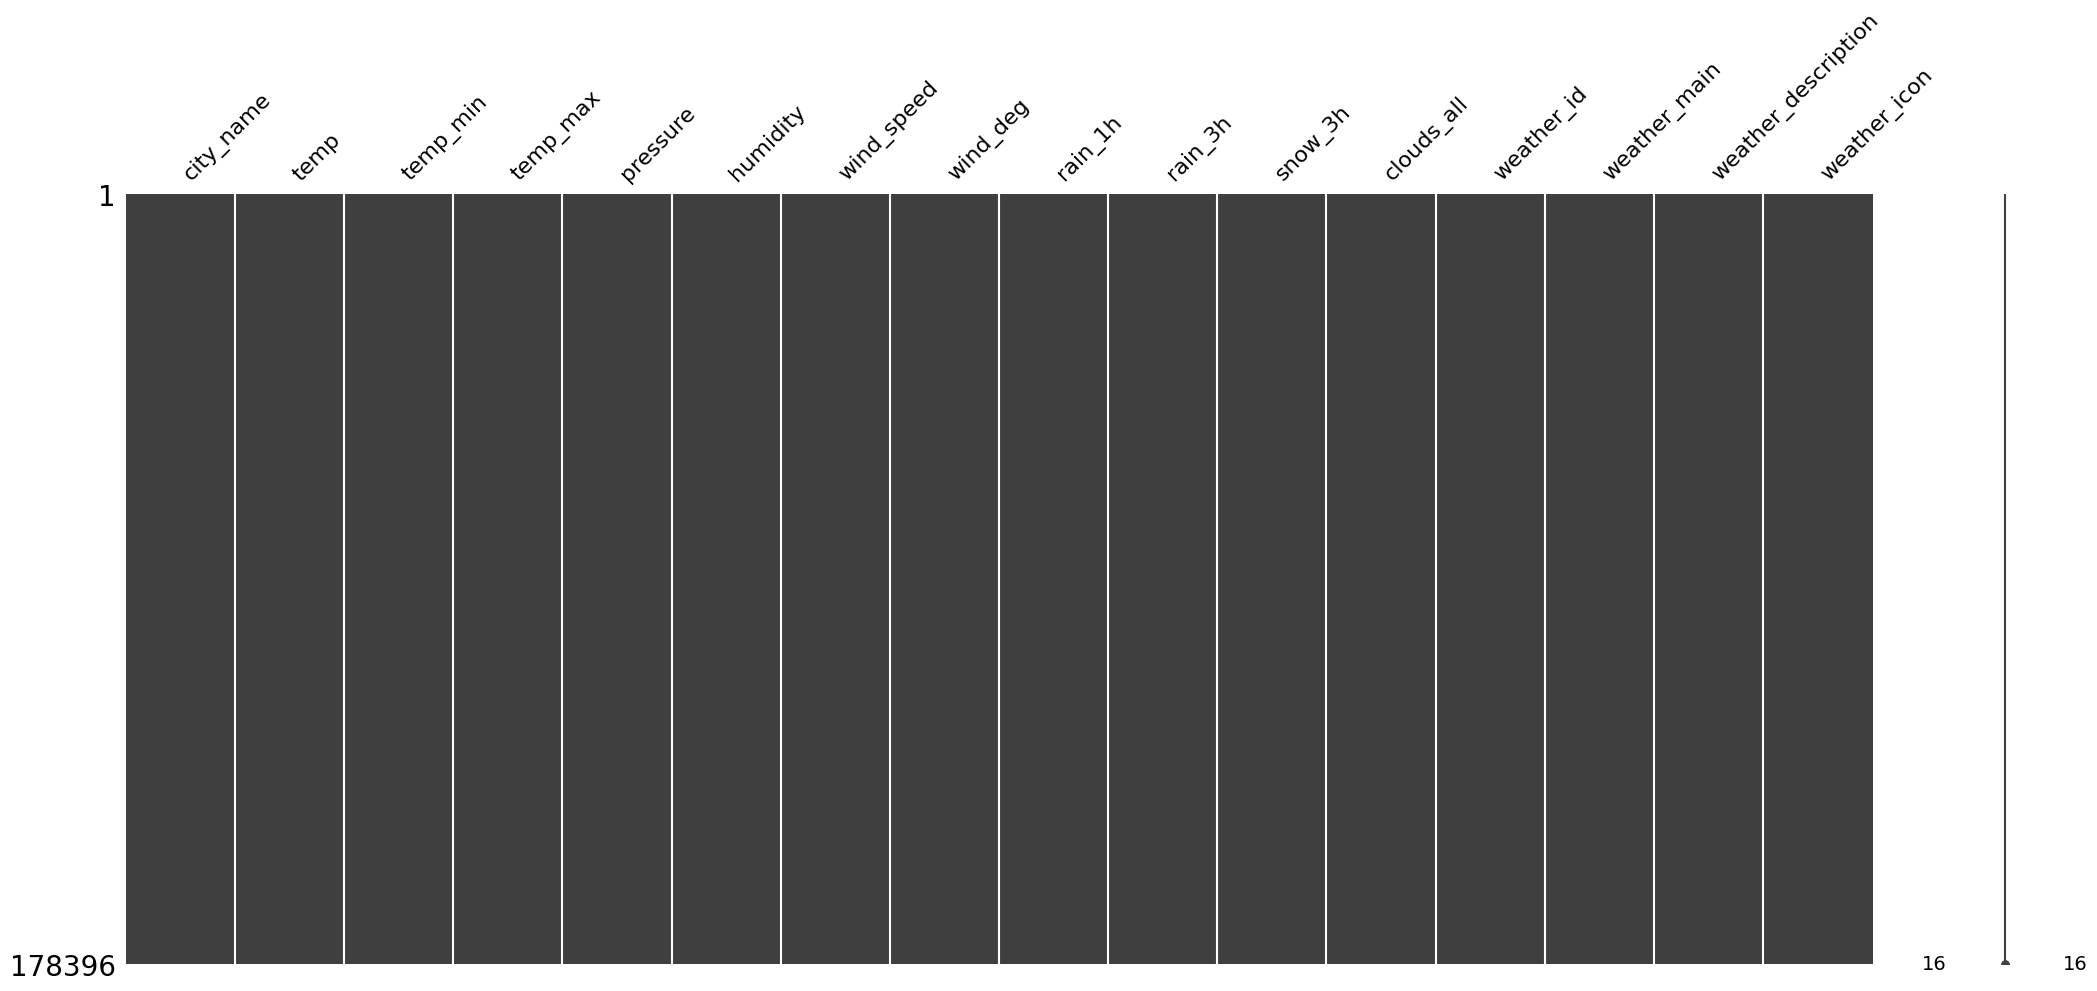

In [37]:
msno.matrix(weather_df)

In [38]:
# Drop columns with all values equal to 0
weather_df = weather_df.loc[:, (weather_df!=0).any(axis=0)]

#### Manage Columns

In [39]:
# drop unnecessary columns
drop_cols = ["rain_3h", "weather_id", "weather_main", "weather_description", "weather_icon"]
weather_df.drop(drop_cols, inplace=True, axis=1, errors="ignore")

#### Basic Transformations

In [40]:
# temperature: kelvin to celsius
temp_cols = [col for col in weather_df.columns if "temp" in col]
weather_df[temp_cols] = weather_df[temp_cols].filter(like="temp").applymap(lambda t: t - 273.15)

In [41]:
# convert int and float64 columns to float32
intcols = list(weather_df.dtypes[weather_df.dtypes == np.int64].index)
weather_df[intcols] = weather_df[intcols].applymap(np.float32)

f64cols = list(weather_df.dtypes[weather_df.dtypes == np.float64].index)
weather_df[f64cols] = weather_df[f64cols].applymap(np.float32)

f32cols = list(weather_df.dtypes[weather_df.dtypes == np.float32].index)

In [42]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city_name   178396 non-null  object 
 1   temp        178396 non-null  float32
 2   temp_min    178396 non-null  float32
 3   temp_max    178396 non-null  float32
 4   pressure    178396 non-null  float32
 5   humidity    178396 non-null  float32
 6   wind_speed  178396 non-null  float32
 7   wind_deg    178396 non-null  float32
 8   rain_1h     178396 non-null  float32
 9   snow_3h     178396 non-null  float32
 10  clouds_all  178396 non-null  float32
dtypes: float32(10), object(1)
memory usage: 9.5+ MB


#### Duplicates

In [43]:
# Remove duplicated rows
weather_df = (
    weather_df
    .reset_index()
    .drop_duplicates(subset=["dt_iso", "city_name"], keep="first")
    .set_index('dt_iso')
)

In [44]:
# Remove duplicated columns
weather_df = weather_df.loc[:, ~weather_df.columns.duplicated(keep='first')]

#### Re-group DataFrames

In [45]:
gb_df = weather_df.groupby("city_name")

In [46]:
def format_df(df: pd.DataFrame, city: str):
    df.drop(columns=['city_name'], inplace=True)
    return df.add_suffix(f"_{city.replace(' ', '')}")

concat_weather_df = pd.concat(
    [format_df(gb_df.get_group(city), city) for city in gb_df.groups.keys()],
    axis=1
).interpolate()

In [47]:
concat_weather_df.head()

,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
dt_iso,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,8.475,8.475,8.475,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,-3.492687,-3.492687,-3.492687,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,-5.825,-5.825,-5.825,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.225,0.225,0.225,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,-2.675,-2.675,-2.675,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
2015-01-01 00:00:00,8.475,8.475,8.475,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,-3.386500,-3.386500,-3.386500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,-5.825,-5.825,-5.825,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.225,0.225,0.225,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,-2.675,-2.675,-2.675,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
2015-01-01 01:00:00,8.136,8.136,8.136,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,-3.898313,-3.898313,-3.898313,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,-6.964,-6.964,-6.964,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.936,0.936,0.936,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,-3.464,-3.464,-3.464,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
2015-01-01 02:00:00,8.136,8.136,8.136,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,-3.946656,-3.946656,-3.946656,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,-6.964,-6.964,-6.964,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.936,0.936,0.936,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,-3.464,-3.464,-3.464,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
2015-01-01 03:00:00,8.136,8.136,8.136,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,-3.664500,-3.664500,-3.664500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,-6.964,-6.964,-6.964,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.936,0.936,0.936,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,-3.464,-3.464,-3.464,1002.0,78.0,0.0,23.0,0.0,0.0,0.0


#### Extreme values

In [48]:
# Calculate the absolute z_scores
num_cols = list(concat_weather_df.select_dtypes(include=['number']).columns)
z_scores = np.abs(st.zscore(concat_weather_df[num_cols]))

In [49]:
z_scores.head()

,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
dt_iso,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,1.225871,1.082302,1.291729,0.018734,1.476776,2.1128,1.194369,0.162464,NaN,0.831186,2.467305,2.249481,2.635211,1.885451,1.093476,1.047112,0.537943,0.322101,0.047956,1.287503,2.246429,2.149215,2.277155,2.014914,0.171791,0.726709,1.112285,0.218344,0.00534,0.696698,2.448733,2.165954,2.491175,2.979737,0.490338,0.793544,1.254569,0.191016,NaN,0.541285,2.807250,2.785548,2.775752,1.254829,0.605043,0.655257,0.820538,0.130726,0.012929,0.810059
2015-01-01 00:00:00,1.225871,1.082302,1.291729,0.018734,1.476776,2.1128,1.194369,0.162464,NaN,0.831186,2.451697,2.233902,2.620030,1.783624,1.093476,1.047112,0.562361,0.322101,0.047956,1.287503,2.246429,2.149215,2.277155,2.014914,0.171791,0.726709,1.112285,0.218344,0.00534,0.696698,2.448733,2.165954,2.491175,2.979737,0.490338,0.793544,1.254569,0.191016,NaN,0.541285,2.807250,2.785548,2.775752,1.254829,0.605043,0.655257,0.820538,0.130726,0.012929,0.810059
2015-01-01 01:00:00,1.276291,1.134791,1.338243,0.018660,1.476776,2.1128,1.286482,0.162464,NaN,0.831186,2.526926,2.308991,2.693199,1.885451,1.093476,0.512409,0.521664,0.322101,0.047956,1.287503,2.368550,2.273308,2.394798,2.014914,0.211979,0.726709,0.817066,0.218344,0.00534,0.696698,2.360763,2.079846,2.412894,2.979737,0.315521,0.276847,1.197058,0.191016,NaN,0.541285,2.916311,2.896826,2.880626,1.171059,0.655861,1.042415,1.144428,0.130726,0.012929,0.810059
2015-01-01 02:00:00,1.276291,1.134791,1.338243,0.018660,1.476776,2.1128,1.286482,0.162464,NaN,0.831186,2.534032,2.316083,2.700110,1.783624,1.093476,0.512409,0.529804,0.322101,0.047956,1.287503,2.368550,2.273308,2.394798,2.014914,0.211979,0.726709,0.817066,0.218344,0.00534,0.696698,2.360763,2.079846,2.412894,2.979737,0.315521,0.276847,1.197058,0.191016,NaN,0.541285,2.916311,2.896826,2.880626,1.171059,0.655861,1.042415,1.144428,0.130726,0.012929,0.810059
2015-01-01 03:00:00,1.276291,1.134791,1.338243,0.018660,1.476776,2.1128,1.286482,0.162464,NaN,0.831186,2.492559,2.274688,2.659773,1.783624,1.093476,0.512409,0.497246,0.322101,0.047956,1.287503,2.368550,2.273308,2.394798,2.014914,0.211979,0.726709,0.817066,0.218344,0.00534,0.696698,2.360763,2.079846,2.412894,2.979737,0.315521,0.276847,1.197058,0.191016,NaN,0.541285,2.916311,2.896826,2.880626,1.171059,0.655861,1.042415,1.144428,0.130726,0.012929,0.810059


In [50]:
# Remove values where z_score is over 2.5 stdev
for col in num_cols:
    concat_weather_df.loc[z_scores[col] > 2.5] = np.nan

In [51]:
# Replace outliers with mean values for that column
means_dict = {col: concat_weather_df[col].mean() for col in num_cols}

In [52]:
concat_weather_df.fillna(value=means_dict, inplace=True)

In [53]:
concat_weather_df.describe()

,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000
mean,16.763691,15.457578,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833986,13.300651,11.745352,15.066151,1019.615662,80.191643,1.690023,148.380661,0.064421,0.000378,41.840424,15.353591,14.023056,16.565601,1017.975220,57.588062,2.033685,170.851639,0.008859,0.0,15.713118,20.235895,18.145229,23.336748,1018.435181,63.148907,2.210334,139.892563,0.006729,0.0,8.503324,17.837444,17.295860,18.393061,1017.870667,66.098312,2.289707,152.328918,0.006116,0.0,17.688360
std,5.515546,5.404221,5.876889,5.986875,13.321172,1.423684,92.624756,0.105105,0.0,20.330616,5.211282,5.353827,5.207079,6.278805,12.796265,1.224595,102.872910,0.146608,0.013630,27.639452,7.505198,7.403609,7.785396,8.718284,20.090439,1.284876,106.039497,0.042085,0.0,21.660280,6.365739,6.601707,7.148044,5.083613,18.265287,1.344947,86.283195,0.036810,0.0,15.723811,5.821254,5.782356,5.975380,5.826214,15.451303,1.517528,101.604156,0.035126,0.0,18.542192
min,0.000000,0.000000,0.000000,594.000000,30.000000,0.000000,0.000000,0.000000,0.0,0.000000,-3.230000,-5.000000,-2.500000,993.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.889000,-7.889000,-7.889000,962.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.030000,-2.000000,1.000000,1002.000000,8.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.309500,-0.309500,-0.309500,987.000000,16.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,13.765000,13.000000,14.211117,1016.000000,69.000000,2.000000,150.000000,0.000000,0.0,0.000000,10.780000,9.000000,12.863914,1018.000000,77.000000,1.000000,90.000000,0.000000,0.000000,20.000000,11.000000,10.000000,12.000000,1017.000000,46.000000,1.000000,105.750000,0.000000,0.0,0.000000,17.045251,15.000000,20.000000,1015.000000,56.000000,1.000000,62.000000,0.000000,0.0,0.000000,15.000000,14.400000,15.468750,1016.000000,60.000000,1.000000,80.000000,0.000000,0.0,0.000000
50%,16.763691,15.457577,17.988033,1018.256531,73.608078,2.489492,191.660278,0.000000,0.0,19.833984,13.300650,11.745351,15.066152,1019.615723,80.191643,1.690023,148.380676,0.000000,0.000000,41.840424,15.353590,14.023056,16.565601,1017.975220,57.588055,2.033685,170.851639,0.000000,0.0,15.713117,20.235895,18.145229,23.336748,1018.435120,63.148903,2.210334,139.892548,0.000000,0.0,0.000000,17.837442,17.295860,18.393063,1017.870605,66.098312,2.289708,152.328918,0.000000,0.0,17.688362
75%,19.510000,18.000000,21.110001,1020.000000,81.000000,3.000000,260.000000,0.027426,0.0,20.000000,15.770000,14.000000,17.439625,1022.000000,88.000000,2.000000

### Merge DataFrames

In [54]:
# Energy & Weather Concat
df = pd.concat([energy_df, concat_weather_df], axis=1)

In [55]:
df.head()

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_sol,gen_waste,gen_wind_on,load_actual,price_dayahead,price,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
2014-12-31 23:00:00,367.0,558.0,5047.0,4659.0,301.0,54.0,872.0,2060.0,6680.0,57.0,88.0,648.0,282.0,4645.0,28918.0,51.49,58.65,16.763691,15.457577,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833984,13.30065,11.745351,15.066152,1019.615723,80.191643,1.690023,148.380676,0.064421,0.000378,41.840424,15.35359,14.023056,16.565601,1017.97522,57.588055,2.033685,170.851639,0.008859,0.0,15.713117,20.235895,18.145229,23.336748,1018.43512,63.148903,2.210334,139.892548,0.006729,0.0,8.503323,17.837442,17.29586,18.393063,1017.870605,66.098312,2.289708,152.328918,0.006116,0.0,17.688362
2015-01-01 00:00:00,367.0,558.0,5047.0,4659.0,301.0,54.0,872.0,2060.0,6680.0,57.0,88.0,648.0,282.0,4645.0,28918.0,51.49,58.65,16.763691,15.457577,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833984,13.30065,11.745351,15.066152,1019.615723,80.191643,1.690023,148.380676,0.064421,0.000378,41.840424,15.35359,14.023056,16.565601,1017.97522,57.588055,2.033685,170.851639,0.008859,0.0,15.713117,20.235895,18.145229,23.336748,1018.43512,63.148903,2.210334,139.892548,0.006729,0.0,8.503323,17.837442,17.29586,18.393063,1017.870605,66.098312,2.289708,152.328918,0.006116,0.0,17.688362
2015-01-01 01:00:00,367.0,558.0,5047.0,4659.0,301.0,54.0,872.0,2060.0,6680.0,57.0,88.0,648.0,282.0,4645.0,28918.0,51.49,58.65,16.763691,15.457577,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833984,13.30065,11.745351,15.066152,1019.615723,80.191643,1.690023,148.380676,0.064421,0.000378,41.840424,15.35359,14.023056,16.565601,1017.97522,57.588055,2.033685,170.851639,0.008859,0.0,15.713117,20.235895,18.145229,23.336748,1018.43512,63.148903,2.210334,139.892548,0.006729,0.0,8.503323,17.837442,17.29586,18.393063,1017.870605,66.098312,2.289708,152.328918,0.006116,0.0,17.688362
2015-01-01 02:00:00,367.0,558.0,5047.0,4659.0,301.0,54.0,872.0,2060.0,6680.0,57.0,88.0,648.0,282.0,4645.0,28918.0,51.49,58.65,16.763691,15.457577,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833984,13.30065,11.745351,15.066152,1019.615723,80.191643,1.690023,148.380676,0.064421,0.000378,41.840424,15.35359,14.023056,16.565601,1017.97522,57.588055,2.033685,170.851639,0.008859,0.0,15.713117,20.235895,18.145229,23.336748,1018.43512,63.148903,2.210334,139.892548,0.006729,0.0,8.503323,17.837442,17.29586,18.393063,1017.870605,66.098312,2.289708,152.328918,0.006116,0.0,17.688362
2015-01-01 03:00:00,367.0,558.0,5047.0,4659.0,301.0,54.0,872.0,2060.0,6680.0,57.0,88.0,648.0,282.0,4645.0,28918.0,51.49,58.65,16.763691,15.457577,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833984,13.30065,11.745351,15.066152,1019.615723,80.191643,1.690023,148.380676,0.064421,0.000378,41.840424,15.35359,14.023056,16.565601,1017.97522,57.588055,2.033685,170.851639,0.008859,0.0,15.713117,20.235895,18.145229,23.336748,1018.43512,63.148903,2.210334,139.892548,0.006729,0.0,8.503323,17.837442,17.29586,18.393063,1017.870605,66.098312,2.289708,152.3289

In [56]:
df.shape

(35064, 67)

In [57]:
df.describe()

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_sol,gen_waste,gen_wind_on,load_actual,price_dayahead,price,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.0,35064.000000
mean,383.675907,487.955168,5478.795460,4462.490303,300.311345,294.619581,931.991016,2395.465235,6374.451660,60.286533,86.595311,1353.226529,275.838838,5056.763204,28775.219313,51.487083,58.895475,16.763691,15.457578,17.988033,1018.256531,73.608078,2.489492,191.660278,0.027426,0.0,19.833986,13.300651,11.745352,15.066151,1019.615662,80.191643,1.690023,148.380661,0.064421,0.000378,41.840424,15.353591,14.023056,16.565601,1017.975220,57.588062,2.033685,170.851639,0.008859,0.0,15.713118,20.235895,18.145229,23.336748,1018.435181,63.148907,2.210334,139.892563,0.006729,0.0,8.503324,17.837444,17.295860,18.393061,1017.870667,66.098312,2.289707,152.328918,0.006116,0.0,17.688360
std,78.436543,316.814664,1666.737831,1714.721215,45.580962,505.492396,350.558603,1527.552195,732.537356,17.188887,12.516925,1587.607736,41.586527,2627.024964,4010.158313,11.136598,11.288587,5.515546,5.404221,5.876889,5.986875,13.321172,1.423684,92.624756,0.105105,0.0,20.330616,5.211282,5.353827,5.207079,6.278805,12.796265,1.224595,102.872910,0.146608,0.013630,27.639452,7.505198,7.403609,7.785396,8.718284,20.090439,1.284876,106.039497,0.042085,0.0,21.660280,6.365739,6.601707,7.148044,5.083613,18.265287,1.344947,86.283195,0.036810,0.0,15.723811,5.821254,5.782356,5.975380,5.826214,15.451303,1.517528,101.604156,0.035126,0.0,18.542192
min,175.000000,0.000000,2317.000000,576.000000,168.000000,0.000000,285.000000,151.000000,4169.000000,10.000000,51.000000,2.000000,144.000000,234.000000,18179.000000,13.460000,22.390000,0.000000,0.000000,0.000000,594.000000,30.000000,0.000000,0.000000,0.000000,0.0,0.000000,-3.230000,-5.000000,-2.500000,993.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.889000,-7.889000,-7.889000,962.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.030000,-2.000000,1.000000,1002.000000,8.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.309500,-0.309500,-0.309500,987.000000,16.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,343.000000,226.000000,4396.000000,3229.750000,275.000000,0.000000,670.000000,1239.000000,5984.000000,55.000000,77.000000,138.000000,258.000000,3221.750000,25743

Define ***Target***

In [58]:
y = df['price']

Define ***Features***
- Features will be *lagged* one observation, as we will be forecasting *one period ahead*

In [59]:
X_forecast = pd.DataFrame(
    index=df.index[-1:] + pd.Timedelta(minutes=60),
    columns=df.columns.tolist()
)

In [60]:
X = (
    pd.concat([df, X_forecast])
    .shift(1)
    .fillna(method='bfill')
    .rename(columns={'price': 'lagged_price'})
)

In [61]:
X.shape

(35065, 67)

In [62]:
pd.concat([y, X[['lagged_price']]], axis=1)

,price,lagged_price
2014-12-31 23:00:00,58.65,58.65
2015-01-01 00:00:00,58.65,58.65
2015-01-01 01:00:00,58.65,58.65
2015-01-01 02:00:00,58.65,58.65
2015-01-01 03:00:00,58.65,58.65
...,...,...
2018-12-31 19:00:00,76.16,77.02
2018-12-31 20:00:00,74.30,76.16
2018-12-31 21:00:00,58.65,74.30
2018-12-31 22:00:00,58.65,58.65


# Feature Engineering

### Features Analysis

In [63]:
# Feature Correlations
df_corr = pd.concat([y, X.loc[X.index.isin(y.index)]], axis=1).corr(method="pearson")

In [64]:
# Find threshold for features filtering
thresh = np.max([np.quantile(np.abs(df_corr['price'].dropna()), 0.25), 0.1])

In [65]:
thresh

0.1

In [66]:
# Pick top features and filter df_corr
top_candidates = list(df_corr.loc[np.abs(df_corr['price']).sort_values() > thresh].index)

In [67]:
len(top_candidates)

17

In [68]:
df_corr = (
    df_corr
    .loc[top_candidates, top_candidates]
    .sort_values(by=['price'], ascending=False)
    .round(3)
)

df_corr = df_corr[df_corr.index.tolist()]

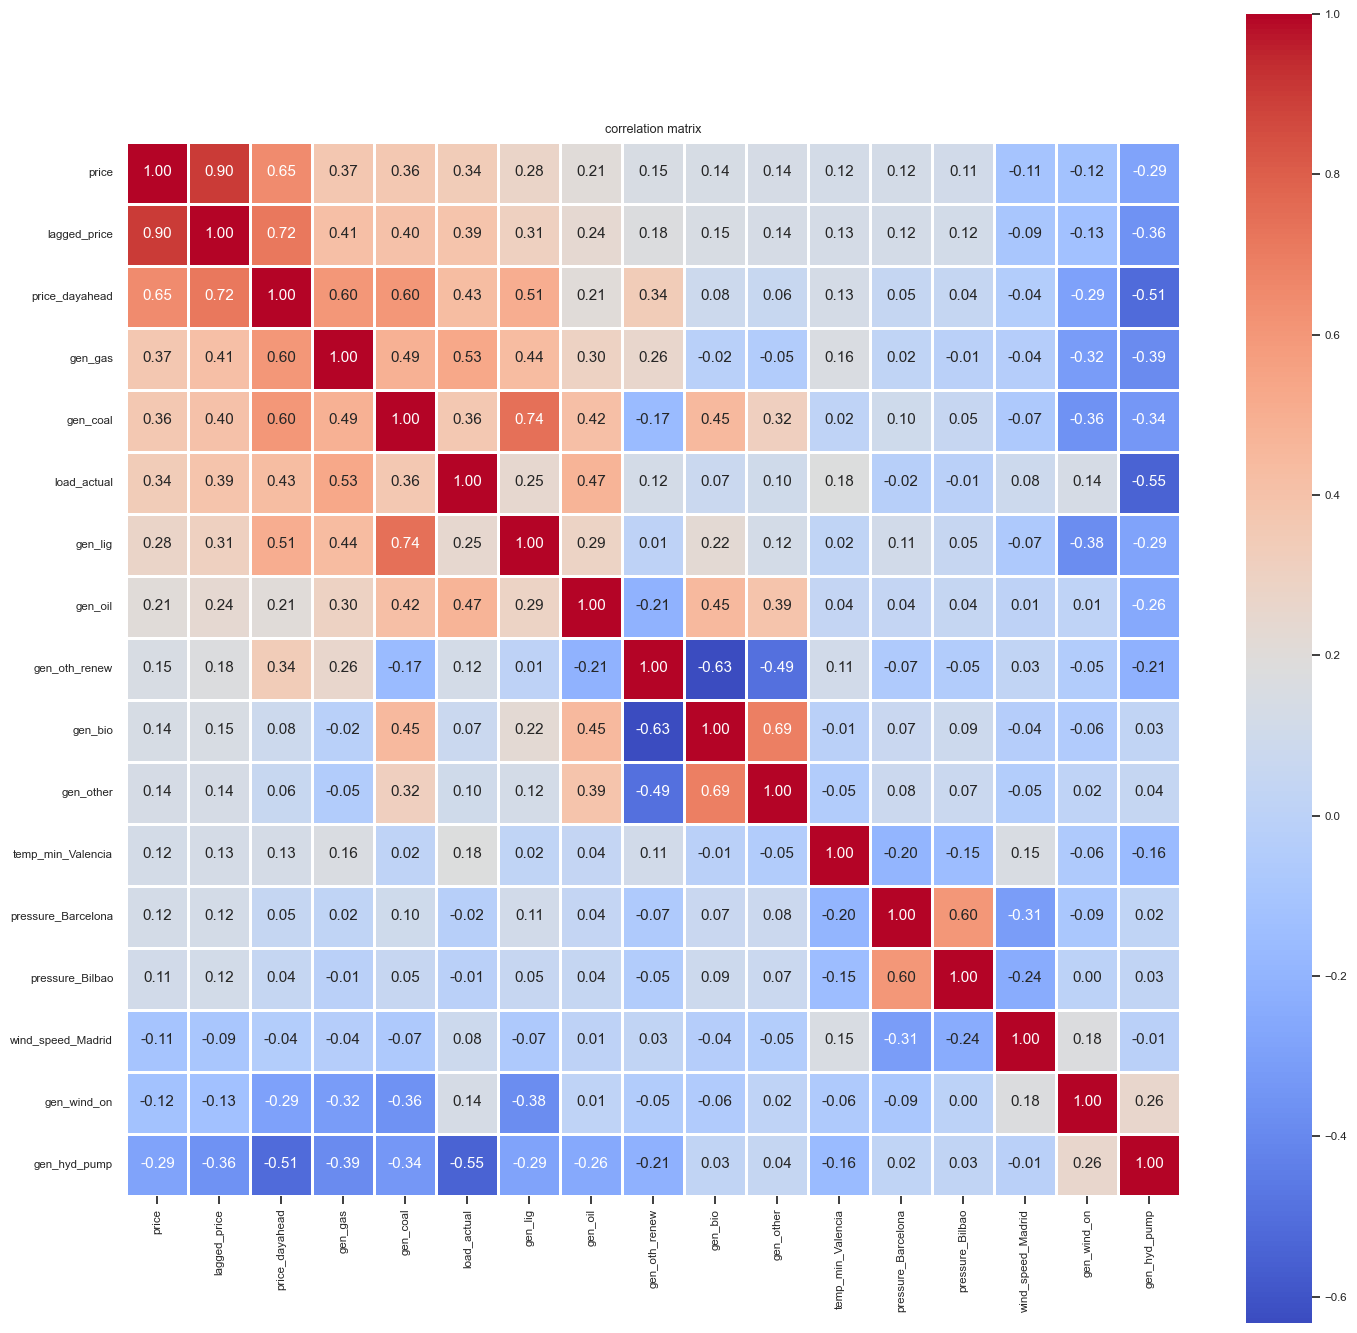

In [69]:
plt.figure(figsize = (17,17))
sns.set(font_scale=0.75)
ax = sns.heatmap(
    df_corr, 
    annot=True, 
    square=True, 
    linewidths=.75, 
    cmap="coolwarm", 
    fmt = ".2f", 
    annot_kws = {"size": 11}
)
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

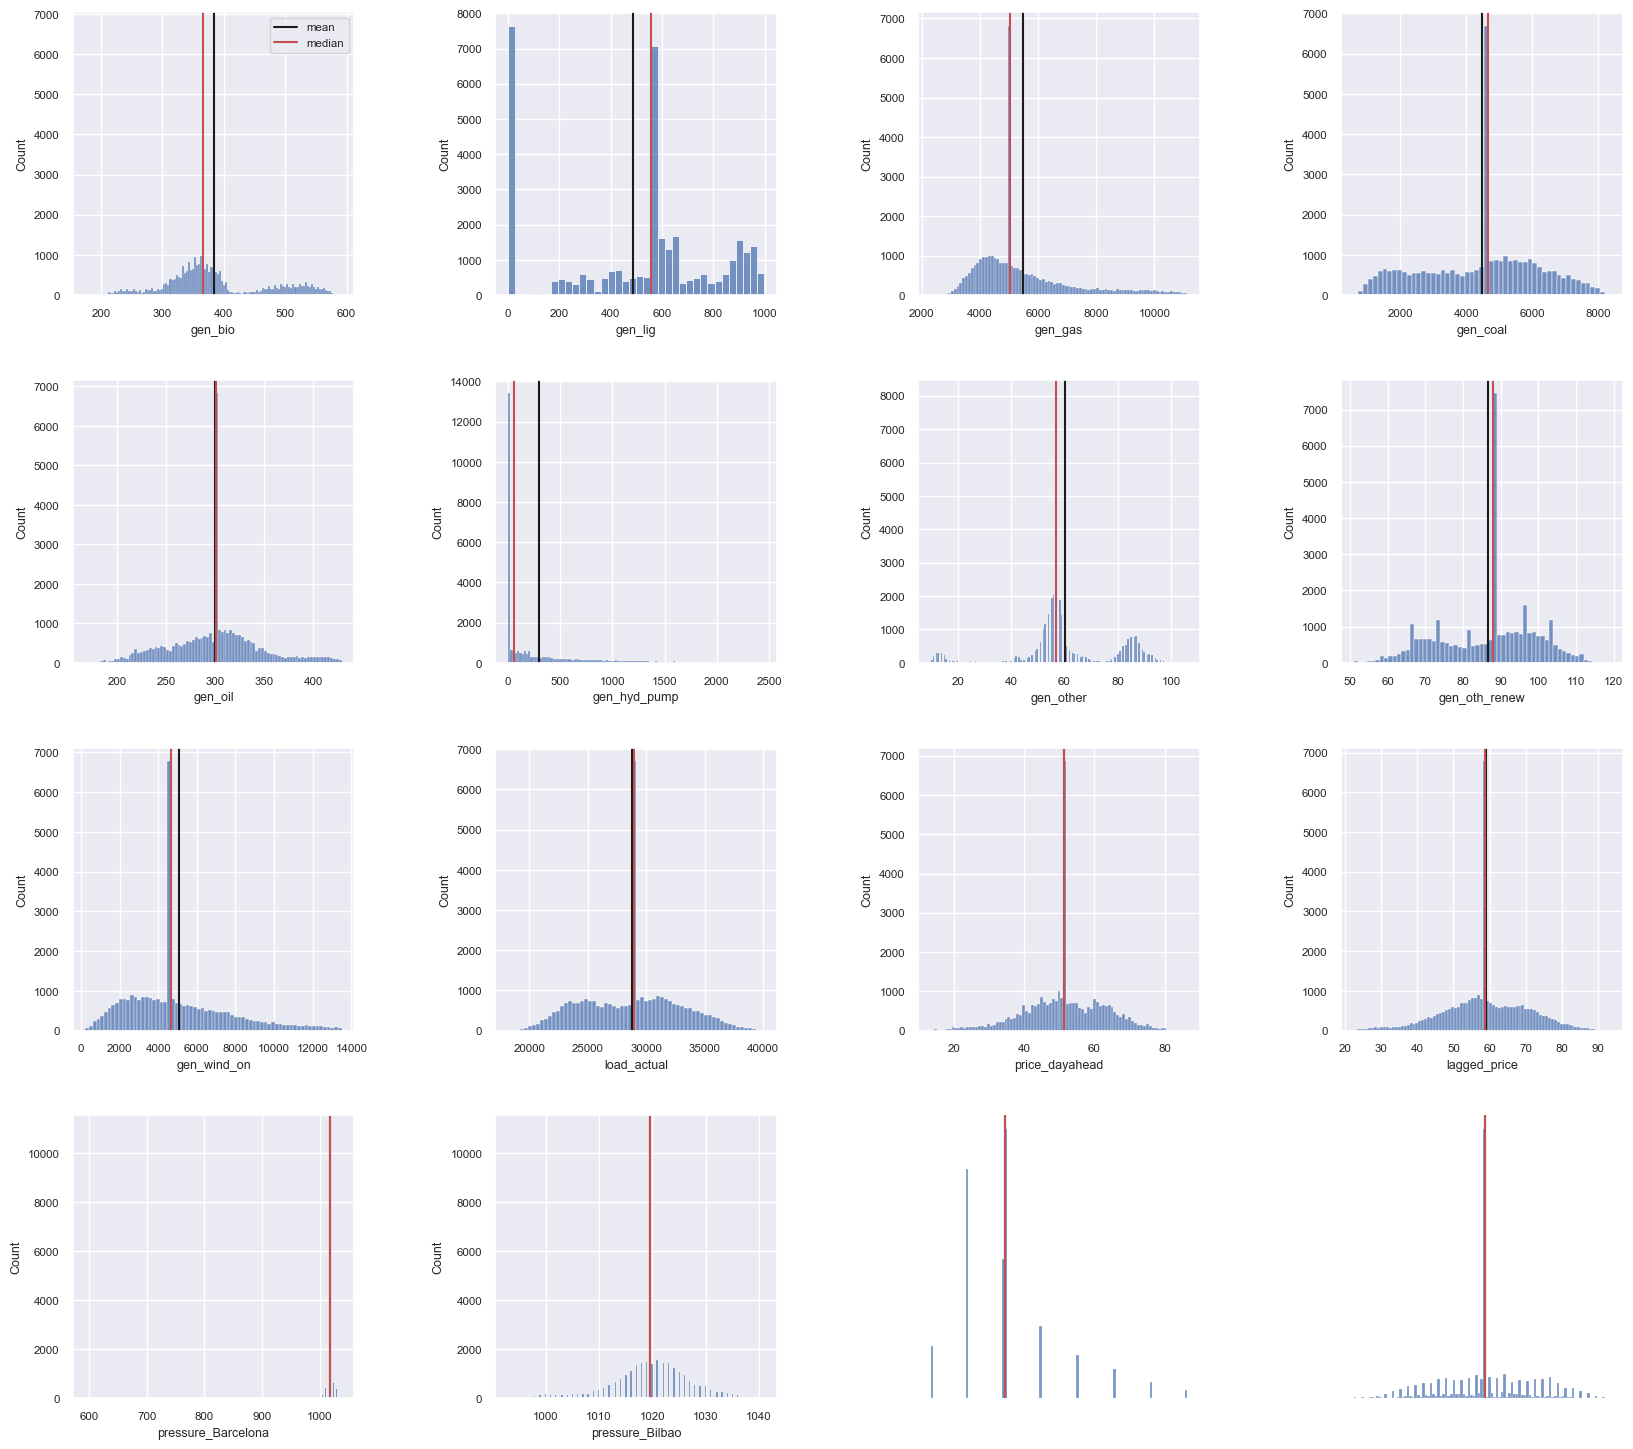

In [70]:
# Plot features distributions
X = X.filter(top_candidates)

rows = int(np.ceil(X.shape[1] / 4))
f, ax = plt.subplots(rows, 4, figsize=(20, rows*4.5), gridspec_kw={'wspace':0.5,'hspace':0.3})

ax = ax.ravel()

for i, col in enumerate(X):
    sns.histplot(X[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=X[col].mean(), color='k', label='mean')
    ax[i].axvline(x=X[col].median(), color='r', label='median')
    
ax[0].legend();
ax[-2].axis('off')
ax[-1].axis('off');

### Feature Enrichment
- There are multiple strategies for enriching features to boost the achievable forecast accuracy of a model.
- This might include techniques like binning, linear combinations of some key features, laggin features, calculating moving average, exponential moing averages, etc.

In [71]:
def find_optimal_seasonal_period(time_series, max_period=None):
    if max_period is None:
        max_period = len(time_series) // 2

    # Perform seasonal decomposition using STL
    decomposition = seasonal_decompose(time_series, period=max_period)

    # Get the seasonal component
    seasonal_component = decomposition.seasonal.dropna()

    # Compute the periodogram
    n = len(seasonal_component)
    fft_values = np.abs(np.fft.fft(seasonal_component)) ** 2
    fft_values = fft_values[:n // 2]
    frequencies = np.fft.fftfreq(n, 1)
    frequencies = frequencies[:n // 2]

    # Find the index of the maximum frequency
    max_index = np.argmax(fft_values)
    # pprint(fft_values)

    # Calculate the optimal seasonal period
    optimal_period = int(1 / frequencies[max_index])

    # Plot the periodogram (optional)
    plt.plot(1 / frequencies, fft_values)
    plt.xlabel('Seasonal Period')
    plt.ylabel('Periodogram')
    plt.title('Periodogram of Seasonal Component')
    plt.show()

    return optimal_period

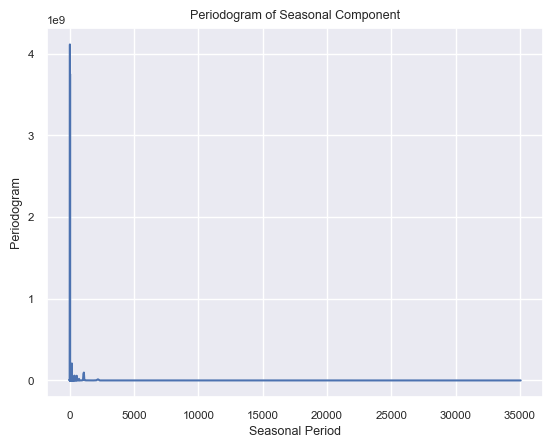

In [72]:
sp = find_optimal_seasonal_period(y.copy(), 24*3*30)

In [73]:
sp

12

In [74]:
lag_periods = list(range(1, sp//2 + 1)) + [sp * i for i in range(1, sp//2 + 1)] + [24*31, 24*365]
rolling_windows = [sp//2, sp, 2*sp]

In [75]:
lag_periods

[1, 2, 3, 4, 5, 6, 12, 24, 36, 48, 60, 72, 744, 8760]

In [76]:
rolling_windows

[6, 12, 24]

In [77]:
# Lagg Features
def lag_df(df_: pd.DataFrame, lag: int):
    df_[df_.columns] = df_[df_.columns].shift(lag, axis=0)
    
    return (
        df_
        .rename(columns=lambda x: f"{x}_lag_{lag}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Simple rolling features
def rolling_df(df_: pd.DataFrame, window: int, agg_fun: str = 'mean'):
    if agg_fun == 'mean':
        df_[df_.columns] = df_.rolling(window=window).mean()
    elif agg_fun == 'std':
        df_[df_.columns] = df_.rolling(window=window).std()
    elif agg_fun == 'max':
        df_[df_.columns] = df_.rolling(window=window).max()
    elif agg_fun == 'min':
        df_[df_.columns] = df_.rolling(window=window).min()
    elif agg_fun == 'min_max':
        df_[df_.columns] = df_.rolling(window=window).max() - df_.rolling(window=window).min()
        
    return (
        df_
        .rename(columns=lambda x: f"{x}_sm_{agg_fun}_{window}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Exponential Moving Average
def ema(df_: pd.DataFrame, window: int):
    # ewm(span=window, adjust=False)
    df_[df_.columns] = df_.ewm(span=window, adjust=False).mean()
    
    return (
        df_
        .rename(columns=lambda x: f"{x}_ema_{window}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Temporal Embedding Features
def tef(df_: pd.DataFrame, dow: bool = True, dom: bool = True, hod: bool = True):
    # Day of Week
    if dow:
        df_['dow_sin'] = np.sin(2 * np.pi * df_.index.dayofweek / 7)
        df_['day_cos'] = np.cos(2 * np.pi * df_.index.dayofweek / 7)
    
    # Day of Month
    if dom:
        df_['dom_sin'] = np.sin(2 * np.pi * df_.index.day / 31)
        df_['dam_cos'] = np.cos(2 * np.pi * df_.index.day / 31)
        
    # Hour of Day
    if hod:
        df_['hod_sin'] = np.sin(2 * np.pi * df_.index.hour / 24)
        df_['hod_cos'] = np.cos(2 * np.pi * df_.index.hour / 24)
        
    return pd.concat([
        df_.filter(like='sin', axis=1), 
        df_.filter(like='cos', axis=1)
    ], axis=1)


# Time Based Features
def tbf(df_: pd.DataFrame):
    # Time-based Features
    df_['month'] = df_.index.month
    df_['day'] = df_.index.day
    df_['day_of_week'] = df_.index.dayofweek
    df_['hour'] = df_.index.hour
    
    return df_[['month', 'day', 'day_of_week', 'hour']]


# Holiday-based features
def extract_holidays(df_: pd.DataFrame):
    spain_holidays = holidays.CountryHoliday('ES', observed=True)
    df_['is_holiday'] = df_.index.to_series().apply(lambda x: x.date() in spain_holidays)
    
    return df_[['is_holiday']]


# Seasonal Decomposition
def extract_stl(target: pd.DataFrame, seasonal_period: int):
    if seasonal_period % 2 == 0:
        seasonal_period += 1
        
    stl = STL(target.values, period=seasonal_period)
    result = stl.fit()
    
    stl_df = pd.concat(
        [pd.Series(result.trend), pd.Series(result.seasonal), pd.Series(result.resid)], axis=1
    ).rename(columns={
        0: 'stl_trend',
        1: 'stl_season',
        2: 'stl_resid'
    })
    stl_df.index = target.index
    
    return stl_df

In [78]:
lag_df = pd.concat(
    [lag_df(X.copy(), lag=lag) for lag in lag_periods],
    axis=1
)

In [79]:
lag_df.tail()

,gen_bio_lag_1,gen_lig_lag_1,gen_gas_lag_1,gen_coal_lag_1,gen_oil_lag_1,gen_hyd_pump_lag_1,gen_other_lag_1,gen_oth_renew_lag_1,gen_wind_on_lag_1,load_actual_lag_1,price_dayahead_lag_1,lagged_price_lag_1,pressure_Barcelona_lag_1,pressure_Bilbao_lag_1,wind_speed_Madrid_lag_1,temp_min_Valencia_lag_1,gen_bio_lag_2,gen_lig_lag_2,gen_gas_lag_2,gen_coal_lag_2,gen_oil_lag_2,gen_hyd_pump_lag_2,gen_other_lag_2,gen_oth_renew_lag_2,gen_wind_on_lag_2,load_actual_lag_2,price_dayahead_lag_2,lagged_price_lag_2,pressure_Barcelona_lag_2,pressure_Bilbao_lag_2,wind_speed_Madrid_lag_2,temp_min_Valencia_lag_2,gen_bio_lag_3,gen_lig_lag_3,gen_gas_lag_3,gen_coal_lag_3,gen_oil_lag_3,gen_hyd_pump_lag_3,gen_other_lag_3,gen_oth_renew_lag_3,gen_wind_on_lag_3,load_actual_lag_3,price_dayahead_lag_3,lagged_price_lag_3,pressure_Barcelona_lag_3,pressure_Bilbao_lag_3,wind_speed_Madrid_lag_3,temp_min_Valencia_lag_3,gen_bio_lag_4,gen_lig_lag_4,gen_gas_lag_4,gen_coal_lag_4,gen_oil_lag_4,gen_hyd_pump_lag_4,gen_other_lag_4,gen_oth_renew_lag_4,gen_wind_on_lag_4,load_actual_lag_4,price_dayahead_lag_4,lagged_price_lag_4,pressure_Barcelona_lag_4,pressure_Bilbao_lag_4,wind_speed_Madrid_lag_4,temp_min_Valencia_lag_4,gen_bio_lag_5,gen_lig_lag_5,gen_gas_lag_5,gen_coal_lag_5,gen_oil_lag_5,gen_hyd_pump_lag_5,gen_other_lag_5,gen_oth_renew_lag_5,gen_wind_on_lag_5,load_actual_lag_5,price_dayahead_lag_5,lagged_price_lag_5,pressure_Barcelona_lag_5,pressure_Bilbao_lag_5,wind_speed_Madrid_lag_5,temp_min_Valencia_lag_5,gen_bio_lag_6,gen_lig_lag_6,gen_gas_lag_6,gen_coal_lag_6,gen_oil_lag_6,gen_hyd_pump_lag_6,gen_other_lag_6,gen_oth_renew_lag_6,gen_wind_on_lag_6,load_actual_lag_6,price_dayahead_lag_6,lagged_price_lag_6,pressure_Barcelona_lag_6,pressure_Bilbao_lag_6,wind_speed_Madrid_lag_6,temp_min_Valencia_lag_6,gen_bio_lag_12,gen_lig_lag_12,gen_gas_lag_12,gen_coal_lag_12,gen_oil_lag_12,gen_hyd_pump_lag_12,gen_other_lag_12,gen_oth_renew_lag_12,gen_wind_on_lag_12,load_actual_lag_12,price_dayahead_lag_12,lagged_price_lag_12,pressure_Barcelona_lag_12,pressure_Bilbao_lag_12,wind_speed_Madrid_lag_12,temp_min_Valencia_lag_12,gen_bio_lag_24,gen_lig_lag_24,gen_gas_lag_24,gen_coal_lag_24,gen_oil_lag_24,gen_hyd_pump_lag_24,gen_other_lag_24,gen_oth_renew_lag_24,gen_wind_on_lag_24,load_actual_lag_24,price_dayahead_lag_24,lagged_price_lag_24,pressure_Barcelona_lag_24,pressure_Bilbao_lag_24,wind_speed_Madrid_lag_24,temp_min_Valencia_lag_24,gen_bio_lag_36,gen_lig_lag_36,gen_gas_lag_36,gen_coal_lag_36,gen_oil_lag_36,gen_hyd_pump_lag_36,gen_other_lag_36,gen_oth_renew_lag_36,gen_wind_on_lag_36,load_actual_lag_36,price_dayahead_lag_36,lagged_price_lag_36,pressure_Barcelona_lag_36,pressure_Bilbao_lag_36,wind_speed_Madrid_lag_36,temp_min_Valencia_lag_36,gen_bio_lag_48,gen_lig_lag_48,gen_gas_lag_48,gen_coal_lag_48,gen_oil_lag_48,gen_hyd_pump_lag_48,gen_other_lag_48,gen_oth_renew_lag_48,gen_wind_on_lag_48,load_actual_lag_48,price_dayahead_lag_48,lagged_price_lag_48,pressure_Barcelona_lag_48,pressure_Bilbao_lag_48,wind_speed_Madrid_lag_48,temp_min_Valencia_lag_48,gen_bio_lag_60,gen_lig_lag_60,gen_gas_lag_60,gen_coal_lag_60,gen_oil_lag_60,gen_hyd_pump_lag_60,gen_other_lag_60,gen_oth_renew_lag_60,gen_wind_on_lag_60,load_actual_lag_60,price_dayahead_lag_60,lagged_price_lag_60,pressure_Barcelona_lag_60,pressure_Bilbao_lag_60,wind_speed_Madrid_lag_60,temp_min_Valencia_lag_60,gen_bio_lag_72,gen_lig_lag_72,gen_gas_lag_72,gen_coal_lag_72,gen_oil_lag_72,gen_hyd_pump_lag_72,gen_other_lag_72,gen_oth_renew_lag_72,gen_wind_on_lag_72,load_actual_lag_72,price_dayahead_lag_72,lagged_price_lag_72,pressure_Barcelona_lag_72,pressure_Bilbao_lag_72,wind_speed_Madrid_lag_72,temp_min_Valencia_lag_72,gen_bio_lag_744,gen_lig_lag_744,gen_gas_lag_744,gen_coal_lag_744,gen_oil_lag_744,gen_hyd_pump_lag_744,gen_other_lag_744,gen_oth_renew_lag_744,gen_wind_on_lag_744,load_actual_lag_744,price_dayahead_lag_744,lagged_price_lag_744,pressure_Barcelona_lag_744,pressure_Bilbao_lag_744,wind_speed_Madrid_lag_744,temp_min_Valencia_lag_744,gen_bio_la

In [80]:
sma_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='mean') for window in rolling_windows],
    axis=1
)

In [81]:
sma_df.tail()

,gen_bio_sm_mean_6,gen_lig_sm_mean_6,gen_gas_sm_mean_6,gen_coal_sm_mean_6,gen_oil_sm_mean_6,gen_hyd_pump_sm_mean_6,gen_other_sm_mean_6,gen_oth_renew_sm_mean_6,gen_wind_on_sm_mean_6,load_actual_sm_mean_6,price_dayahead_sm_mean_6,lagged_price_sm_mean_6,pressure_Barcelona_sm_mean_6,pressure_Bilbao_sm_mean_6,wind_speed_Madrid_sm_mean_6,temp_min_Valencia_sm_mean_6,gen_bio_sm_mean_12,gen_lig_sm_mean_12,gen_gas_sm_mean_12,gen_coal_sm_mean_12,gen_oil_sm_mean_12,gen_hyd_pump_sm_mean_12,gen_other_sm_mean_12,gen_oth_renew_sm_mean_12,gen_wind_on_sm_mean_12,load_actual_sm_mean_12,price_dayahead_sm_mean_12,lagged_price_sm_mean_12,pressure_Barcelona_sm_mean_12,pressure_Bilbao_sm_mean_12,wind_speed_Madrid_sm_mean_12,temp_min_Valencia_sm_mean_12,gen_bio_sm_mean_24,gen_lig_sm_mean_24,gen_gas_sm_mean_24,gen_coal_sm_mean_24,gen_oil_sm_mean_24,gen_hyd_pump_sm_mean_24,gen_other_sm_mean_24,gen_oth_renew_sm_mean_24,gen_wind_on_sm_mean_24,load_actual_sm_mean_24,price_dayahead_sm_mean_24,lagged_price_sm_mean_24,pressure_Barcelona_sm_mean_24,pressure_Bilbao_sm_mean_24,wind_speed_Madrid_sm_mean_24,temp_min_Valencia_sm_mean_24
2018-12-31 19:00:00,296.666667,0.0,6781.333333,2586.166667,183.500000,172.333333,61.000000,94.000000,2567.333333,28071.500000,66.565000,73.986667,1027.166667,1033.166667,0.833333,18.000000,300.250000,0.0,6567.750000,2574.666667,197.666667,88.000000,59.166667,92.916667,2672.083333,28335.333333,65.456667,72.420000,1028.250000,1033.833333,0.666667,13.166667,293.666667,0.00,6051.750000,2070.625000,208.375000,190.958333,57.125000,94.000000,3437.541667,26242.583333,62.030833,68.245833,1026.011777,1031.086609,1.090351,11.353304
2018-12-31 20:00:00,296.500000,0.0,6977.833333,2564.166667,177.166667,131.500000,61.333333,94.166667,2733.833333,28362.666667,67.136667,74.688333,1027.000000,1033.166667,1.000000,16.333333,299.333333,0.0,6658.666667,2595.666667,194.833333,88.000000,59.583333,93.333333,2679.666667,28649.166667,66.156667,73.213333,1028.083333,1033.833333,0.666667,13.750000,294.541667,0.00,6116.666667,2112.708333,206.416667,190.958333,57.333333,93.916667,3349.291667,26229.791667,62.054583,68.362917,1026.011777,1031.086609,1.090351,11.436638
2018-12-31 21:00:00,296.000000,0.0,7127.333333,2551.000000,175.500000,83.333333,61.500000,94.500000,2945.500000,28539.666667,67.586667,75.263333,1027.166667,1033.333333,1.000000,14.333333,298.166667,0.0,6711.500000,2594.500000,191.166667,92.083333,60.000000,93.666667,2705.750000,28623.250000,66.315833,73.544167,1028.000000,1033.833333,0.750000,14.250000,295.250000,0.00,6165.250000,2146.291667,204.416667,193.000000,57.500000,93.833333,3278.875000,26139.875000,61.991250,68.390417,1026.053444,1031.044942,1.132018,11.561638
2018-12-31 22:00:00,307.166667,93.0,6905.333333,2910.333333,196.000000,38.500000,60.833333,93.166667,3341.833333,28951.166667,65.368333,73.145000,1027.333333,1033.500000,1.166667,11.833333,303.166667,46.5,6591.750000,2777.666667,197.500000,96.500000,60.083333,93.166667,2851.250000,28543.666667,65.116667,72.421667,1027.833333,1033.750000,0.916667,14.333333,298.750000,23.25,6139.708333,2273.333333,208.000000,195.208333,57.500000,93.416667,3267.750000,26130.416667,61.318333,67.837500,1026.459422,1031.644287,1.130614,11.090977
2018-12-31 23:00:00,318.666667,186.0,6597.833333,3256.333333,216.666667,26.833333,60.166667,92.000000,3691.000000,29314.500000,62.615000,70.398333,1027.500000,1033.666667,1.166667,9.333333,308.500000,93.0,6465.666667,2945.083333,205.083333,100.916667,60.000000,92.916667,3022.750000,28474.083333,63.990000,71.325000,1027.666667,1033.666667,0.916667,13.916667,302.208333,46.50,6116.541667,2399.875000,211.166667,197.416667,57.541667,93.000000,3273.875000,26213.083333,60.744167,67.385833,1026.459422,1031.602620,1.088947,11.090977


In [82]:
sm_std_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='std') for window in rolling_windows],
    axis=1
)

In [83]:
sm_std_df.tail()

,gen_bio_sm_std_6,gen_lig_sm_std_6,gen_gas_sm_std_6,gen_coal_sm_std_6,gen_oil_sm_std_6,gen_hyd_pump_sm_std_6,gen_other_sm_std_6,gen_oth_renew_sm_std_6,gen_wind_on_sm_std_6,load_actual_sm_std_6,price_dayahead_sm_std_6,lagged_price_sm_std_6,pressure_Barcelona_sm_std_6,pressure_Bilbao_sm_std_6,wind_speed_Madrid_sm_std_6,temp_min_Valencia_sm_std_6,gen_bio_sm_std_12,gen_lig_sm_std_12,gen_gas_sm_std_12,gen_coal_sm_std_12,gen_oil_sm_std_12,gen_hyd_pump_sm_std_12,gen_other_sm_std_12,gen_oth_renew_sm_std_12,gen_wind_on_sm_std_12,load_actual_sm_std_12,price_dayahead_sm_std_12,lagged_price_sm_std_12,pressure_Barcelona_sm_std_12,pressure_Bilbao_sm_std_12,wind_speed_Madrid_sm_std_12,temp_min_Valencia_sm_std_12,gen_bio_sm_std_24,gen_lig_sm_std_24,gen_gas_sm_std_24,gen_coal_sm_std_24,gen_oil_sm_std_24,gen_hyd_pump_sm_std_24,gen_other_sm_std_24,gen_oth_renew_sm_std_24,gen_wind_on_sm_std_24,load_actual_sm_std_24,price_dayahead_sm_std_24,lagged_price_sm_std_24,pressure_Barcelona_sm_std_24,pressure_Bilbao_sm_std_24,wind_speed_Madrid_sm_std_24,temp_min_Valencia_sm_std_24
2018-12-31 19:00:00,2.422120,0.000000,707.707190,75.835128,13.967820,152.938768,1.095445,1.673320,380.911888,1704.269316,2.131523,2.984055,0.408248,0.408248,0.408248,3.405877,4.826536,0.000000,538.321993,136.071060,18.182576,135.683455,2.208798,2.151462,375.620567,1520.311112,2.349732,2.982869,1.215431,0.834847,0.492366,7.004328,9.594685,0.000000,677.385463,537.287698,16.859554,255.573435,2.802367,2.245769,963.768192,3629.168175,6.354891,6.632225,4.164045,6.053489,0.726714,7.077808
2018-12-31 20:00:00,2.428992,0.000000,627.124682,52.442031,1.602082,161.787206,1.032796,1.722401,447.443144,1831.625580,2.077466,2.903249,0.000000,0.408248,0.000000,4.926121,4.458563,0.000000,553.275919,108.922269,19.054149,135.683455,2.234373,2.015095,387.899315,1368.557358,1.751406,2.538777,1.240112,0.834847,0.492366,6.239537,8.737621,0.000000,714.166383,534.775408,18.019112,255.573435,2.973311,2.165273,867.884759,3615.710273,6.378527,6.750008,4.164045,6.053489,0.726714,7.035975
2018-12-31 21:00:00,3.033150,0.000000,471.663722,76.068390,3.987480,126.918346,0.836660,1.378405,463.247990,1722.727102,1.528943,2.261793,0.408248,0.516398,0.000000,5.537749,4.386619,0.000000,555.658086,110.845921,19.673856,133.547716,1.954017,1.723281,433.211921,1376.995420,1.720272,2.382762,1.206045,0.834847,0.452267,5.395705,7.713624,0.000000,735.225564,527.484719,19.511238,254.181893,3.064524,2.119612,775.424502,3537.928887,6.320061,6.773744,4.179339,6.028773,0.689178,6.942681
2018-12-31 22:00:00,29.403515,227.802546,957.539903,859.717318,51.579066,48.788318,2.041241,2.786874,715.325217,1385.294108,6.833732,7.203074,0.516398,0.547723,0.408248,5.307228,20.386419,161.080725,735.034832,601.278386,36.550090,131.115841,1.781640,2.367712,709.269807,1324.808071,4.621217,4.928036,1.029857,0.753778,0.514929,5.245489,16.248746,113.901273,763.639767,723.465913,27.712813,252.666988,3.064524,2.244155,752.553407,3529.839840,6.548127,7.010562,3.849221,5.538186,0.687294,6.919892
2018-12-31 23:00:00,37.484219,288.149961,1222.317539,1088.849056,65.426804,28.336666,2.562551,3.286335,761.339609,883.869391,8.644584,9.168654,0.547723,0.516398,0.408248,4.082483,27.477263,217.201205,860.101403,806.996053,47.252625,128.472465,1.906925,2.745520,870.133963,1276.565596,6.070452,6.338866,0.778499,0.651339,0.514929,5.791190,21.085703,157.540057,788.653943,857.730337,33.481555,251.122682,3.050006,2.284161,763.520013,3572.452317,6.786373,7.244749,3.849221,5.515557,0.662149,6.919892


In [84]:
sm_max_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='max') for window in rolling_windows],
    axis=1
)

In [85]:
sm_max_df.tail()

,gen_bio_sm_max_6,gen_lig_sm_max_6,gen_gas_sm_max_6,gen_coal_sm_max_6,gen_oil_sm_max_6,gen_hyd_pump_sm_max_6,gen_other_sm_max_6,gen_oth_renew_sm_max_6,gen_wind_on_sm_max_6,load_actual_sm_max_6,price_dayahead_sm_max_6,lagged_price_sm_max_6,pressure_Barcelona_sm_max_6,pressure_Bilbao_sm_max_6,wind_speed_Madrid_sm_max_6,temp_min_Valencia_sm_max_6,gen_bio_sm_max_12,gen_lig_sm_max_12,gen_gas_sm_max_12,gen_coal_sm_max_12,gen_oil_sm_max_12,gen_hyd_pump_sm_max_12,gen_other_sm_max_12,gen_oth_renew_sm_max_12,gen_wind_on_sm_max_12,load_actual_sm_max_12,price_dayahead_sm_max_12,lagged_price_sm_max_12,pressure_Barcelona_sm_max_12,pressure_Bilbao_sm_max_12,wind_speed_Madrid_sm_max_12,temp_min_Valencia_sm_max_12,gen_bio_sm_max_24,gen_lig_sm_max_24,gen_gas_sm_max_24,gen_coal_sm_max_24,gen_oil_sm_max_24,gen_hyd_pump_sm_max_24,gen_other_sm_max_24,gen_oth_renew_sm_max_24,gen_wind_on_sm_max_24,load_actual_sm_max_24,price_dayahead_sm_max_24,lagged_price_sm_max_24,pressure_Barcelona_sm_max_24,pressure_Bilbao_sm_max_24,wind_speed_Madrid_sm_max_24,temp_min_Valencia_sm_max_24
2018-12-31 19:00:00,300.0,0.0,7634.0,2698.0,212.0,339.0,63.0,96.0,3113.0,30653.0,68.85,77.61,1028.0,1034.0,1.0,21.0,307.0,0.0,7634.0,2773.0,225.0,339.0,63.0,96.0,3197.0,30653.0,68.85,77.61,1030.0,1035.0,1.0,21.0,307.0,0.0,7634.0,2773.0,225.0,708.0,63.0,98.0,5406.0,30653.0,68.85,77.61,1030.0,1035.0,2.033685,21.0
2018-12-31 20:00:00,300.0,0.0,7634.0,2628.0,178.0,339.0,63.0,96.0,3288.0,30653.0,68.85,77.61,1027.0,1034.0,1.0,21.0,307.0,0.0,7634.0,2773.0,225.0,339.0,63.0,96.0,3288.0,30653.0,68.85,77.61,1030.0,1035.0,1.0,21.0,307.0,0.0,7634.0,2773.0,225.0,708.0,63.0,98.0,5193.0,30653.0,68.85,77.61,1030.0,1035.0,2.033685,21.0
2018-12-31 21:00:00,300.0,0.0,7634.0,2628.0,178.0,323.0,63.0,96.0,3503.0,30653.0,68.85,77.61,1028.0,1034.0,1.0,21.0,307.0,0.0,7634.0,2773.0,225.0,339.0,63.0,96.0,3503.0,30653.0,68.85,77.61,1030.0,1035.0,1.0,21.0,307.0,0.0,7634.0,2773.0,225.0,708.0,63.0,98.0,4912.0,30653.0,68.85,77.61,1030.0,1035.0,2.033685,21.0
2018-12-31 22:00:00,367.0,558.0,7634.0,4659.0,301.0,124.0,63.0,95.0,4645.0,30653.0,68.85,77.61,1028.0,1034.0,2.0,20.0,367.0,558.0,7634.0,4659.0,301.0,339.0,63.0,96.0,4645.0,30653.0,68.85,77.61,1030.0,1035.0,2.0,21.0,367.0,558.0,7634.0,4659.0,301.0,708.0,63.0,98.0,4645.0,30653.0,68.85,77.61,1030.0,1035.0,2.033685,21.0
2018-12-31 23:00:00,367.0,558.0,7634.0,4659.0,301.0,54.0,63.0,95.0,4645.0,30653.0,68.85,77.61,1028.0,1034.0,2.0,16.0,367.0,558.0,7634.0,4659.0,301.0,339.0,63.0,96.0,4645.0,30653.0,68.85,77.61,1029.0,1035.0,2.0,21.0,367.0,558.0,7634.0,4659.0,301.0,708.0,63.0,96.0,4645.0,30653.0,68.85,77.61,1030.0,1035.0,2.033685,21.0


In [86]:
sm_min_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='min') for window in rolling_windows],
    axis=1
)

In [87]:
sm_min_df.tail()

,gen_bio_sm_min_6,gen_lig_sm_min_6,gen_gas_sm_min_6,gen_coal_sm_min_6,gen_oil_sm_min_6,gen_hyd_pump_sm_min_6,gen_other_sm_min_6,gen_oth_renew_sm_min_6,gen_wind_on_sm_min_6,load_actual_sm_min_6,price_dayahead_sm_min_6,lagged_price_sm_min_6,pressure_Barcelona_sm_min_6,pressure_Bilbao_sm_min_6,wind_speed_Madrid_sm_min_6,temp_min_Valencia_sm_min_6,gen_bio_sm_min_12,gen_lig_sm_min_12,gen_gas_sm_min_12,gen_coal_sm_min_12,gen_oil_sm_min_12,gen_hyd_pump_sm_min_12,gen_other_sm_min_12,gen_oth_renew_sm_min_12,gen_wind_on_sm_min_12,load_actual_sm_min_12,price_dayahead_sm_min_12,lagged_price_sm_min_12,pressure_Barcelona_sm_min_12,pressure_Bilbao_sm_min_12,wind_speed_Madrid_sm_min_12,temp_min_Valencia_sm_min_12,gen_bio_sm_min_24,gen_lig_sm_min_24,gen_gas_sm_min_24,gen_coal_sm_min_24,gen_oil_sm_min_24,gen_hyd_pump_sm_min_24,gen_other_sm_min_24,gen_oth_renew_sm_min_24,gen_wind_on_sm_min_24,load_actual_sm_min_24,price_dayahead_sm_min_24,lagged_price_sm_min_24,pressure_Barcelona_sm_min_24,pressure_Bilbao_sm_min_24,wind_speed_Madrid_sm_min_24,temp_min_Valencia_sm_min_24
2018-12-31 19:00:00,293.0,0.0,6062.0,2501.0,177.0,1.0,60.0,92.0,2233.0,26449.0,64.18,70.85,1027.0,1033.0,0.0,12.0,293.0,0.0,6062.0,2314.0,177.0,1.0,56.0,90.0,2233.0,25969.0,60.00,66.64,1027.0,1033.0,0.0,2.0,275.0,0.0,5116.0,1340.0,177.0,1.0,53.0,90.0,2233.0,20006.0,50.89,57.04,1018.256531,1019.615723,0.0,2.0
2018-12-31 20:00:00,293.0,0.0,6128.0,2501.0,174.0,1.0,60.0,92.0,2233.0,26449.0,64.18,70.85,1027.0,1033.0,1.0,9.0,293.0,0.0,6062.0,2436.0,174.0,1.0,56.0,90.0,2233.0,26449.0,64.18,70.33,1027.0,1033.0,0.0,2.0,275.0,0.0,5116.0,1340.0,174.0,1.0,53.0,90.0,2233.0,20006.0,50.89,57.04,1018.256531,1019.615723,0.0,2.0
2018-12-31 21:00:00,292.0,0.0,6379.0,2422.0,168.0,1.0,61.0,92.0,2267.0,26449.0,64.80,71.36,1027.0,1033.0,1.0,8.0,292.0,0.0,6062.0,2422.0,168.0,1.0,56.0,91.0,2233.0,26449.0,64.18,70.85,1027.0,1033.0,0.0,5.0,283.0,0.0,5116.0,1340.0,168.0,1.0,53.0,90.0,2233.0,20006.0,50.89,57.04,1018.256531,1019.615723,0.0,2.0
2018-12-31 22:00:00,292.0,0.0,5047.0,2422.0,168.0,1.0,57.0,88.0,2550.0,26738.0,51.49,58.65,1027.0,1033.0,1.0,6.0,292.0,0.0,5047.0,2422.0,168.0,1.0,57.0,88.0,2233.0,26449.0,51.49,58.65,1027.0,1033.0,0.0,6.0,284.0,0.0,5047.0,1340.0,168.0,1.0,53.0,88.0,2233.0,20006.0,50.89,57.04,1018.256531,1019.615723,0.0,2.0
2018-12-31 23:00:00,292.0,0.0,5047.0,2422.0,168.0,1.0,57.0,88.0,2952.0,28071.0,51.49,58.65,1027.0,1033.0,1.0,5.0,292.0,0.0,5047.0,2422.0,168.0,1.0,57.0,88.0,2233.0,26449.0,51.49,58.65,1027.0,1033.0,0.0,5.0,285.0,0.0,5047.0,1340.0,168.0,1.0,53.0,88.0,2233.0,20006.0,50.89,57.04,1018.256531,1019.615723,0.0,2.0


In [88]:
sm_min_max_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='min_max') for window in rolling_windows],
    axis=1
)

In [89]:
sm_min_max_df.tail()

,gen_bio_sm_min_max_6,gen_lig_sm_min_max_6,gen_gas_sm_min_max_6,gen_coal_sm_min_max_6,gen_oil_sm_min_max_6,gen_hyd_pump_sm_min_max_6,gen_other_sm_min_max_6,gen_oth_renew_sm_min_max_6,gen_wind_on_sm_min_max_6,load_actual_sm_min_max_6,price_dayahead_sm_min_max_6,lagged_price_sm_min_max_6,pressure_Barcelona_sm_min_max_6,pressure_Bilbao_sm_min_max_6,wind_speed_Madrid_sm_min_max_6,temp_min_Valencia_sm_min_max_6,gen_bio_sm_min_max_12,gen_lig_sm_min_max_12,gen_gas_sm_min_max_12,gen_coal_sm_min_max_12,gen_oil_sm_min_max_12,gen_hyd_pump_sm_min_max_12,gen_other_sm_min_max_12,gen_oth_renew_sm_min_max_12,gen_wind_on_sm_min_max_12,load_actual_sm_min_max_12,price_dayahead_sm_min_max_12,lagged_price_sm_min_max_12,pressure_Barcelona_sm_min_max_12,pressure_Bilbao_sm_min_max_12,wind_speed_Madrid_sm_min_max_12,temp_min_Valencia_sm_min_max_12,gen_bio_sm_min_max_24,gen_lig_sm_min_max_24,gen_gas_sm_min_max_24,gen_coal_sm_min_max_24,gen_oil_sm_min_max_24,gen_hyd_pump_sm_min_max_24,gen_other_sm_min_max_24,gen_oth_renew_sm_min_max_24,gen_wind_on_sm_min_max_24,load_actual_sm_min_max_24,price_dayahead_sm_min_max_24,lagged_price_sm_min_max_24,pressure_Barcelona_sm_min_max_24,pressure_Bilbao_sm_min_max_24,wind_speed_Madrid_sm_min_max_24,temp_min_Valencia_sm_min_max_24
2018-12-31 19:00:00,7.0,0.0,1572.0,197.0,35.0,338.0,3.0,4.0,880.0,4204.0,4.67,6.76,1.0,1.0,1.0,9.0,14.0,0.0,1572.0,459.0,48.0,338.0,7.0,6.0,964.0,4684.0,8.85,10.97,3.0,2.0,1.0,19.0,32.0,0.0,2518.0,1433.0,48.0,707.0,10.0,8.0,3173.0,10647.0,17.96,20.57,11.743469,15.384277,2.033685,19.0
2018-12-31 20:00:00,7.0,0.0,1506.0,127.0,4.0,338.0,3.0,4.0,1055.0,4204.0,4.67,6.76,0.0,1.0,0.0,12.0,14.0,0.0,1572.0,337.0,51.0,338.0,7.0,6.0,1055.0,4204.0,4.67,7.28,3.0,2.0,1.0,19.0,32.0,0.0,2518.0,1433.0,51.0,707.0,10.0,8.0,2960.0,10647.0,17.96,20.57,11.743469,15.384277,2.033685,19.0
2018-12-31 21:00:00,8.0,0.0,1255.0,206.0,10.0,322.0,2.0,4.0,1236.0,4204.0,4.05,6.25,1.0,1.0,0.0,13.0,15.0,0.0,1572.0,351.0,57.0,338.0,7.0,5.0,1270.0,4204.0,4.67,6.76,3.0,2.0,1.0,16.0,24.0,0.0,2518.0,1433.0,57.0,707.0,10.0,8.0,2679.0,10647.0,17.96,20.57,11.743469,15.384277,2.033685,19.0
2018-12-31 22:00:00,75.0,558.0,2587.0,2237.0,133.0,123.0,6.0,7.0,2095.0,3915.0,17.36,18.96,1.0,1.0,1.0,14.0,75.0,558.0,2587.0,2237.0,133.0,338.0,6.0,8.0,2412.0,4204.0,17.36,18.96,3.0,2.0,2.0,15.0,83.0,558.0,2587.0,3319.0,133.0,707.0,10.0,10.0,2412.0,10647.0,17.96,20.57,11.743469,15.384277,2.033685,19.0
2018-12-31 23:00:00,75.0,558.0,2587.0,2237.0,133.0,53.0,6.0,7.0,1693.0,2582.0,17.36,18.96,1.0,1.0,1.0,11.0,75.0,558.0,2587.0,2237.0,133.0,338.0,6.0,8.0,2412.0,4204.0,17.36,18.96,2.0,2.0,2.0,16.0,82.0,558.0,2587.0,3319.0,133.0,707.0,10.0,8.0,2412.0,10647.0,17.96,20.57,11.743469,15.384277,2.033685,19.0


In [90]:
ema_df = pd.concat(
    [ema(X.copy(), window=window) for window in rolling_windows],
    axis=1
)

In [91]:
ema_df.tail()

,gen_bio_ema_6,gen_lig_ema_6,gen_gas_ema_6,gen_coal_ema_6,gen_oil_ema_6,gen_hyd_pump_ema_6,gen_other_ema_6,gen_oth_renew_ema_6,gen_wind_on_ema_6,load_actual_ema_6,price_dayahead_ema_6,lagged_price_ema_6,pressure_Barcelona_ema_6,pressure_Bilbao_ema_6,wind_speed_Madrid_ema_6,temp_min_Valencia_ema_6,gen_bio_ema_12,gen_lig_ema_12,gen_gas_ema_12,gen_coal_ema_12,gen_oil_ema_12,gen_hyd_pump_ema_12,gen_other_ema_12,gen_oth_renew_ema_12,gen_wind_on_ema_12,load_actual_ema_12,price_dayahead_ema_12,lagged_price_ema_12,pressure_Barcelona_ema_12,pressure_Bilbao_ema_12,wind_speed_Madrid_ema_12,temp_min_Valencia_ema_12,gen_bio_ema_24,gen_lig_ema_24,gen_gas_ema_24,gen_coal_ema_24,gen_oil_ema_24,gen_hyd_pump_ema_24,gen_other_ema_24,gen_oth_renew_ema_24,gen_wind_on_ema_24,load_actual_ema_24,price_dayahead_ema_24,lagged_price_ema_24,pressure_Barcelona_ema_24,pressure_Bilbao_ema_24,wind_speed_Madrid_ema_24,temp_min_Valencia_ema_24
2018-12-31 19:00:00,297.022676,3.086301e-07,7006.626434,2582.974881,184.192825,98.600948,60.971007,93.912965,2750.428701,28663.029727,66.985960,74.624238,1027.277007,1033.165344,0.903574,15.750978,296.965963,0.012539,6623.234235,2458.909202,193.617739,138.856638,59.594695,93.735283,2839.240708,27794.079618,65.077971,72.208196,1027.253594,1032.898582,0.886529,14.504862,293.755815,2.745100,6221.319188,2224.800470,204.582709,200.388876,58.555168,94.366858,3298.907297,26918.752537,62.982085,69.619558,1026.830986,1032.286901,0.998420,12.830824
2018-12-31 20:00:00,296.730483,2.204501e-07,7073.590310,2578.124915,181.280589,70.714963,61.265005,94.223546,2904.020501,28969.306948,67.389971,75.063027,1027.197862,1033.403817,0.931124,13.822127,296.817353,0.010610,6718.275122,2475.384709,190.599625,117.647925,59.964742,93.929855,2908.280599,28092.682753,65.589052,72.816166,1027.214579,1033.068031,0.903986,13.657960,293.935350,2.525492,6302.893653,2252.096433,202.136092,184.437766,58.830755,94.417509,3298.034713,27144.052334,63.415518,70.142793,1026.844507,1032.423949,0.998547,12.524358
2018-12-31 21:00:00,295.378917,1.574643e-07,7059.707364,2533.517796,177.486135,64.796402,61.189289,94.159676,3075.157501,28712.647820,67.244265,74.845019,1027.427044,1033.574155,0.950803,12.158662,296.076222,0.008978,6765.463565,2467.171677,187.122760,107.240552,60.124012,93.940646,2999.775891,28089.346945,65.787659,73.044448,1027.335413,1033.211411,0.918757,12.787505,293.780522,2.323453,6360.662161,2265.688718,199.405205,173.682745,59.004294,94.384108,3314.431936,27218.208148,63.692677,70.475370,1026.936947,1032.550033,0.998663,12.162410
2018-12-31 22:00:00,315.842083,1.594286e+02,6484.648117,3140.798426,212.775811,61.711716,59.992349,92.399769,3523.683929,28771.319871,62.743047,70.217871,1027.590746,1033.695825,1.250574,10.399045,306.987573,85.853750,6501.084555,2804.376035,204.642335,99.049698,59.643395,93.026701,3252.887293,28216.832031,63.588020,70.829917,1027.437657,1033.332732,1.085102,11.743273,299.638080,46.777577,6255.569188,2457.153621,207.532788,164.108125,58.843951,93.873380,3420.877381,27354.191496,62.716463,69.529340,1027.021991,1032.666031,1.078770,11.669417
2018-12-31 23:00:00,330.458631,2.733061e+02,6073.891512,3574.570304,237.982722,59.508368,59.137392,91.142692,3844.059949,28813.228479,59.527890,66.912765,1027.707676,1033.782732,1.178981,8.856460,316.220254,158.491635,6277.379239,3089.702798,219.466591,92.118975,59.236719,92.253362,3467.058478,28324.704026,61.726786,68.956084,1027.524172,1033.435389,1.072010,10.705847,305.027034,87.675371,6158.883653,2633.301331,215.010165,155.299475,58.696435,93.403509,3518.807191,27479.296176,61.818346,68.658993,1027.100232,1032.772748,1.072468,11.135864


In [92]:
tef_df = tef(X.copy())

In [93]:
tef_df.tail()

,dow_sin,dom_sin,hod_sin,day_cos,dam_cos,hod_cos
2018-12-31 19:00:00,0.0,-2.449294e-16,-0.965926,1.0,1.0,0.258819
2018-12-31 20:00:00,0.0,-2.449294e-16,-0.866025,1.0,1.0,0.500000
2018-12-31 21:00:00,0.0,-2.449294e-16,-0.707107,1.0,1.0,0.707107
2018-12-31 22:00:00,0.0,-2.449294e-16,-0.500000,1.0,1.0,0.866025
2018-12-31 23:00:00,0.0,-2.449294e-16,-0.258819,1.0,1.0,0.965926


In [94]:
tbf_df = tbf(X.copy())

In [95]:
tbf_df.tail()

,month,day,day_of_week,hour
2018-12-31 19:00:00,12,31,0,19
2018-12-31 20:00:00,12,31,0,20
2018-12-31 21:00:00,12,31,0,21
2018-12-31 22:00:00,12,31,0,22
2018-12-31 23:00:00,12,31,0,23


In [96]:
holiday_df = extract_holidays(X.copy())

In [97]:
holiday_df.tail()

,is_holiday
2018-12-31 19:00:00,False
2018-12-31 20:00:00,False
2018-12-31 21:00:00,False
2018-12-31 22:00:00,False
2018-12-31 23:00:00,False


In [98]:
stl_df = extract_stl(target=X['lagged_price'], seasonal_period=sp)

In [99]:
stl_df.tail()

,stl_trend,stl_season,stl_resid
2018-12-31 19:00:00,70.304005,-1.080991,7.796985
2018-12-31 20:00:00,70.375598,-0.791029,6.575431
2018-12-31 21:00:00,70.444644,0.821272,3.034084
2018-12-31 22:00:00,70.506669,-1.440437,-10.416233
2018-12-31 23:00:00,70.558749,-0.948627,-10.960122


In [100]:
# Concatenate extracted DataFrames
X = pd.concat([
    X, lag_df, sma_df, sm_std_df, sm_max_df, sm_min_df, 
    sm_min_max_df, ema_df, tef_df, tbf_df, holiday_df, stl_df
], axis=1)

In [101]:
X.tail()

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_other,gen_oth_renew,gen_wind_on,load_actual,price_dayahead,lagged_price,pressure_Barcelona,pressure_Bilbao,wind_speed_Madrid,temp_min_Valencia,gen_bio_lag_1,gen_lig_lag_1,gen_gas_lag_1,gen_coal_lag_1,gen_oil_lag_1,gen_hyd_pump_lag_1,gen_other_lag_1,gen_oth_renew_lag_1,gen_wind_on_lag_1,load_actual_lag_1,price_dayahead_lag_1,lagged_price_lag_1,pressure_Barcelona_lag_1,pressure_Bilbao_lag_1,wind_speed_Madrid_lag_1,temp_min_Valencia_lag_1,gen_bio_lag_2,gen_lig_lag_2,gen_gas_lag_2,gen_coal_lag_2,gen_oil_lag_2,gen_hyd_pump_lag_2,gen_other_lag_2,gen_oth_renew_lag_2,gen_wind_on_lag_2,load_actual_lag_2,price_dayahead_lag_2,lagged_price_lag_2,pressure_Barcelona_lag_2,pressure_Bilbao_lag_2,wind_speed_Madrid_lag_2,temp_min_Valencia_lag_2,gen_bio_lag_3,gen_lig_lag_3,gen_gas_lag_3,gen_coal_lag_3,gen_oil_lag_3,gen_hyd_pump_lag_3,gen_other_lag_3,gen_oth_renew_lag_3,gen_wind_on_lag_3,load_actual_lag_3,price_dayahead_lag_3,lagged_price_lag_3,pressure_Barcelona_lag_3,pressure_Bilbao_lag_3,wind_speed_Madrid_lag_3,temp_min_Valencia_lag_3,gen_bio_lag_4,gen_lig_lag_4,gen_gas_lag_4,gen_coal_lag_4,gen_oil_lag_4,gen_hyd_pump_lag_4,gen_other_lag_4,gen_oth_renew_lag_4,gen_wind_on_lag_4,load_actual_lag_4,price_dayahead_lag_4,lagged_price_lag_4,pressure_Barcelona_lag_4,pressure_Bilbao_lag_4,wind_speed_Madrid_lag_4,temp_min_Valencia_lag_4,gen_bio_lag_5,gen_lig_lag_5,gen_gas_lag_5,gen_coal_lag_5,gen_oil_lag_5,gen_hyd_pump_lag_5,gen_other_lag_5,gen_oth_renew_lag_5,gen_wind_on_lag_5,load_actual_lag_5,price_dayahead_lag_5,lagged_price_lag_5,pressure_Barcelona_lag_5,pressure_Bilbao_lag_5,wind_speed_Madrid_lag_5,temp_min_Valencia_lag_5,gen_bio_lag_6,gen_lig_lag_6,gen_gas_lag_6,gen_coal_lag_6,gen_oil_lag_6,gen_hyd_pump_lag_6,gen_other_lag_6,gen_oth_renew_lag_6,gen_wind_on_lag_6,load_actual_lag_6,price_dayahead_lag_6,lagged_price_lag_6,pressure_Barcelona_lag_6,pressure_Bilbao_lag_6,wind_speed_Madrid_lag_6,temp_min_Valencia_lag_6,gen_bio_lag_12,gen_lig_lag_12,gen_gas_lag_12,gen_coal_lag_12,gen_oil_lag_12,gen_hyd_pump_lag_12,gen_other_lag_12,gen_oth_renew_lag_12,gen_wind_on_lag_12,load_actual_lag_12,price_dayahead_lag_12,lagged_price_lag_12,pressure_Barcelona_lag_12,pressure_Bilbao_lag_12,wind_speed_Madrid_lag_12,temp_min_Valencia_lag_12,gen_bio_lag_24,gen_lig_lag_24,gen_gas_lag_24,gen_coal_lag_24,gen_oil_lag_24,gen_hyd_pump_lag_24,gen_other_lag_24,gen_oth_renew_lag_24,gen_wind_on_lag_24,load_actual_lag_24,price_dayahead_lag_24,lagged_price_lag_24,pressure_Barcelona_lag_24,pressure_Bilbao_lag_24,wind_speed_Madrid_lag_24,temp_min_Valencia_lag_24,gen_bio_lag_36,gen_lig_lag_36,gen_gas_lag_36,gen_coal_lag_36,gen_oil_lag_36,gen_hyd_pump_lag_36,gen_other_lag_36,gen_oth_renew_lag_36,gen_wind_on_lag_36,load_actual_lag_36,price_dayahead_lag_36,lagged_price_lag_36,pressure_Barcelona_lag_36,pressure_Bilbao_lag_36,wind_speed_Madrid_lag_36,temp_min_Valencia_lag_36,gen_bio_lag_48,gen_lig_lag_48,gen_gas_lag_48,gen_coal_lag_48,gen_oil_lag_48,gen_hyd_pump_lag_48,gen_other_lag_48,gen_oth_renew_lag_48,gen_wind_on_lag_48,load_actual_lag_48,price_dayahead_lag_48,lagged_price_lag_48,pressure_Barcelona_lag_48,pressure_Bilbao_lag_48,wind_speed_Madrid_lag_48,temp_min_Valencia_lag_48,gen_bio_lag_60,gen_lig_lag_60,gen_gas_lag_60,gen_coal_lag_60,gen_oil_lag_60,gen_hyd_pump_lag_60,gen_other_lag_60,gen_oth_renew_lag_60,gen_wind_on_lag_60,load_actual_lag_60,price_dayahead_lag_60,lagged_price_lag_60,pressure_Barcelona_lag_60,pressure_Bilbao_lag_60,wind_speed_Madrid_lag_60,temp_min_Valencia_lag_60,gen_bio_lag_72,gen_lig_lag_72,gen_gas_lag_72,gen_coal_lag_72,gen_oil_lag_72,gen_hyd_pump_lag_72,gen_other_lag_72,gen_oth_renew_lag_72,gen_wind_on_lag_72,load_actual_lag_72,price_dayahead_lag_72,lagged_price_lag_72,pressure_Barcelona_lag_72,pressure_Bilbao_lag_72,wind_speed_Madrid_lag_72,temp_min_Valencia_lag_72,gen_bio_lag_744,gen_lig_lag_744,gen_gas_lag_744,gen_coal_lag_744,gen_oil_lag_744,gen_hyd_pump_lag_744,gen_other_lag_744,gen_oth_renew_lag_

In [102]:
X.shape

(35065, 542)

In [103]:
X.isna().sum().sum()

0

### Feature Standardizing
- Since all features are numerical, OneHotEncoding will not be needed
- We will use the StandardScaler to transform the numerical featuers

In [104]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_stand = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=X.columns,
    index=X.index
)

In [105]:
X_stand.head()

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_other,gen_oth_renew,gen_wind_on,load_actual,price_dayahead,lagged_price,pressure_Barcelona,pressure_Bilbao,wind_speed_Madrid,temp_min_Valencia,gen_bio_lag_1,gen_lig_lag_1,gen_gas_lag_1,gen_coal_lag_1,gen_oil_lag_1,gen_hyd_pump_lag_1,gen_other_lag_1,gen_oth_renew_lag_1,gen_wind_on_lag_1,load_actual_lag_1,price_dayahead_lag_1,lagged_price_lag_1,pressure_Barcelona_lag_1,pressure_Bilbao_lag_1,wind_speed_Madrid_lag_1,temp_min_Valencia_lag_1,gen_bio_lag_2,gen_lig_lag_2,gen_gas_lag_2,gen_coal_lag_2,gen_oil_lag_2,gen_hyd_pump_lag_2,gen_other_lag_2,gen_oth_renew_lag_2,gen_wind_on_lag_2,load_actual_lag_2,price_dayahead_lag_2,lagged_price_lag_2,pressure_Barcelona_lag_2,pressure_Bilbao_lag_2,wind_speed_Madrid_lag_2,temp_min_Valencia_lag_2,gen_bio_lag_3,gen_lig_lag_3,gen_gas_lag_3,gen_coal_lag_3,gen_oil_lag_3,gen_hyd_pump_lag_3,gen_other_lag_3,gen_oth_renew_lag_3,gen_wind_on_lag_3,load_actual_lag_3,price_dayahead_lag_3,lagged_price_lag_3,pressure_Barcelona_lag_3,pressure_Bilbao_lag_3,wind_speed_Madrid_lag_3,temp_min_Valencia_lag_3,gen_bio_lag_4,gen_lig_lag_4,gen_gas_lag_4,gen_coal_lag_4,gen_oil_lag_4,gen_hyd_pump_lag_4,gen_other_lag_4,gen_oth_renew_lag_4,gen_wind_on_lag_4,load_actual_lag_4,price_dayahead_lag_4,lagged_price_lag_4,pressure_Barcelona_lag_4,pressure_Bilbao_lag_4,wind_speed_Madrid_lag_4,temp_min_Valencia_lag_4,gen_bio_lag_5,gen_lig_lag_5,gen_gas_lag_5,gen_coal_lag_5,gen_oil_lag_5,gen_hyd_pump_lag_5,gen_other_lag_5,gen_oth_renew_lag_5,gen_wind_on_lag_5,load_actual_lag_5,price_dayahead_lag_5,lagged_price_lag_5,pressure_Barcelona_lag_5,pressure_Bilbao_lag_5,wind_speed_Madrid_lag_5,temp_min_Valencia_lag_5,gen_bio_lag_6,gen_lig_lag_6,gen_gas_lag_6,gen_coal_lag_6,gen_oil_lag_6,gen_hyd_pump_lag_6,gen_other_lag_6,gen_oth_renew_lag_6,gen_wind_on_lag_6,load_actual_lag_6,price_dayahead_lag_6,lagged_price_lag_6,pressure_Barcelona_lag_6,pressure_Bilbao_lag_6,wind_speed_Madrid_lag_6,temp_min_Valencia_lag_6,gen_bio_lag_12,gen_lig_lag_12,gen_gas_lag_12,gen_coal_lag_12,gen_oil_lag_12,gen_hyd_pump_lag_12,gen_other_lag_12,gen_oth_renew_lag_12,gen_wind_on_lag_12,load_actual_lag_12,price_dayahead_lag_12,lagged_price_lag_12,pressure_Barcelona_lag_12,pressure_Bilbao_lag_12,wind_speed_Madrid_lag_12,temp_min_Valencia_lag_12,gen_bio_lag_24,gen_lig_lag_24,gen_gas_lag_24,gen_coal_lag_24,gen_oil_lag_24,gen_hyd_pump_lag_24,gen_other_lag_24,gen_oth_renew_lag_24,gen_wind_on_lag_24,load_actual_lag_24,price_dayahead_lag_24,lagged_price_lag_24,pressure_Barcelona_lag_24,pressure_Bilbao_lag_24,wind_speed_Madrid_lag_24,temp_min_Valencia_lag_24,gen_bio_lag_36,gen_lig_lag_36,gen_gas_lag_36,gen_coal_lag_36,gen_oil_lag_36,gen_hyd_pump_lag_36,gen_other_lag_36,gen_oth_renew_lag_36,gen_wind_on_lag_36,load_actual_lag_36,price_dayahead_lag_36,lagged_price_lag_36,pressure_Barcelona_lag_36,pressure_Bilbao_lag_36,wind_speed_Madrid_lag_36,temp_min_Valencia_lag_36,gen_bio_lag_48,gen_lig_lag_48,gen_gas_lag_48,gen_coal_lag_48,gen_oil_lag_48,gen_hyd_pump_lag_48,gen_other_lag_48,gen_oth_renew_lag_48,gen_wind_on_lag_48,load_actual_lag_48,price_dayahead_lag_48,lagged_price_lag_48,pressure_Barcelona_lag_48,pressure_Bilbao_lag_48,wind_speed_Madrid_lag_48,temp_min_Valencia_lag_48,gen_bio_lag_60,gen_lig_lag_60,gen_gas_lag_60,gen_coal_lag_60,gen_oil_lag_60,gen_hyd_pump_lag_60,gen_other_lag_60,gen_oth_renew_lag_60,gen_wind_on_lag_60,load_actual_lag_60,price_dayahead_lag_60,lagged_price_lag_60,pressure_Barcelona_lag_60,pressure_Bilbao_lag_60,wind_speed_Madrid_lag_60,temp_min_Valencia_lag_60,gen_bio_lag_72,gen_lig_lag_72,gen_gas_lag_72,gen_coal_lag_72,gen_oil_lag_72,gen_hyd_pump_lag_72,gen_other_lag_72,gen_oth_renew_lag_72,gen_wind_on_lag_72,load_actual_lag_72,price_dayahead_lag_72,lagged_price_lag_72,pressure_Barcelona_lag_72,pressure_Bilbao_lag_72,wind_speed_Madrid_lag_72,temp_min_Valencia_lag_72,gen_bio_lag_744,gen_lig_lag_744,gen_gas_lag_744,gen_coal_lag_744,gen_oil_lag_744,gen_hyd_pump_lag_744,gen_other_lag_744,gen_oth_renew_lag_

### Feature Selection
- Similarly to the feature enrichment section, there are multiple ways to select the best subset of features that will aid our model, without overfitting.
- We will start by filtering features based on their correlation with the **target**
- Then, we will then filter out **colinear** features
- Finally, we will leverage the **sklearn.feature_selection**, **boruta** and **tsfresh** libraries to select the best features.

In [106]:
# Target-Feature Correlation Based Filtering
def target_feature_correl_filter(
    y: pd.Series,
    X: pd.DataFrame,
    q_thresh: float = 0.3,
    debug: bool = False
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)
    num_cols = list(X.select_dtypes(include=['number']).columns)

    y = y.loc[intersection]
    X = X.loc[intersection, num_cols]

    # Calculate Correlations with target
    tf_corr_df = pd.DataFrame(columns=[y.name])
    for c in X.columns:
        tf_corr_df.loc[c] = [abs(y.corr(X[c]))]
    
    tf_corr_df = tf_corr_df.sort_values(by=[y.name], ascending=False)
    
    if debug:
        logger.debug(f'{tf_corr_df.head()}\n')

    # Define threshold
    threshold = np.quantile(tf_corr_df[y.name].dropna(), q_thresh)
    
    return tf_corr_df.loc[tf_corr_df[y.name] > threshold].index.tolist()

In [107]:
X_stand.shape

(35065, 542)

In [108]:
correl_filter = target_feature_correl_filter(
    y=y.copy(),
    X=X_stand.copy(),
    q_thresh=0.3,
    debug=False
)

In [109]:
X_stand = X_stand.loc[:, correl_filter]

In [110]:
X_stand.shape

(35065, 379)

In [111]:
def colinear_feature_filter(
    X: pd.DataFrame,
    thresh: float = 0.9
):
    cm = pd.DataFrame(X.corr().applymap(lambda x: 100 * np.abs(x))).fillna(100)
    filtered_features = cm.columns.tolist()
    
    i = 0
    while i < len(filtered_features):
        keep_feature = filtered_features[i]
        skip_features = cm.loc[
            (cm[keep_feature] < 100) &
            (cm[keep_feature] >= thresh*100)
        ][keep_feature].index.tolist()
        
        if len(skip_features) > 0:
            filtered_features = [c for c in filtered_features if c not in skip_features]
        i += 1
    
    return filtered_features

In [112]:
colinear_filter = colinear_feature_filter(
    X_stand.copy(), 
    thresh=0.9
)

In [113]:
X_stand = X_stand.loc[:, colinear_filter]

In [114]:
X_stand.shape

(35065, 245)

In [115]:
def select_k_best_features(
    y: pd.Series,
    X: pd.DataFrame,
    perc: float = 0.1
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)
    
    binary_features = [col for col in X.columns if X[col].nunique() == 2]
    non_binary_features = [col for col in X.columns if X[col].nunique() > 2]

    y = y.loc[intersection]
    X_binary = X.loc[intersection, binary_features]
    X_non_binary = X.loc[intersection, non_binary_features]
    
    # Prepare selected_featuers
    selected_featuers = []
    
    # Select Binary Features
    if X_binary.shape[1] > 0:
        k = int(perc * len(binary_features))
        
        selector = SelectKBest(score_func=mutual_info_regression, k=k)
        selector.fit(X_binary, y)

        selected_featuers.extend(X_binary.columns[selector.get_support()].tolist())
    
    # Select Non-Binary Features
    if X_non_binary.shape[1] > 0:
        k = int(perc * len(non_binary_features))
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X_non_binary, y)

        selected_featuers.extend(X_non_binary.columns[selector.get_support()].tolist())
        
    return selected_featuers

In [116]:
k_best_features = select_k_best_features(
    y.copy(),
    X_stand.copy(),
    perc=0.2
)

In [117]:
len(k_best_features)

49

In [118]:
def select_boruta_features(
    y: pd.Series,
    X: pd.DataFrame,
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)

    y = y.loc[intersection]
    X = X.loc[intersection]
    
    # Choose the model
    model = LGBMRegressor(num_iterations=100, random_state=23111997)

    # Instanciate and fit the BorutaPy estimator
    boruta = BorutaPy(model, n_estimators='auto', verbose=0, random_state=23111997)            
    boruta.fit(
        np.array(X), 
        np.array(y)
    )

    # Extract features
    return X.columns[boruta.support_].tolist()

In [119]:
def select_tsfresh_features(
    y: pd.Series,
    X: pd.DataFrame,
    p_value: float = 0.01,
    top_k: int = None
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)

    y = y.loc[intersection]
    X = X.loc[intersection]
    
    # Run TSFresh Feature Selection
    relevance_table = tsf.feature_selection.relevance.calculate_relevance_table(X, y)
    relevance_table = relevance_table[relevance_table.relevant].sort_values("p_value")
    relevance_table = relevance_table.loc[relevance_table['p_value'] < p_value]
    
    selected_featuers = list(relevance_table["feature"].values)
    
    # Extract Features
    if top_k is not None:
        return selected_featuers[:top_k]
    return selected_featuers

In [120]:
tsfresh_features = select_tsfresh_features(
    y.copy(),
    X_stand.copy(),
    p_value=0.01,
    top_k=50
)

In [121]:
len(tsfresh_features)

50

In [122]:
# Merge Features
selected_features = list(set(k_best_features + tsfresh_features))

In [123]:
len(selected_features)

52

In [124]:
X_stand = X_stand.loc[:, selected_features]

In [125]:
X_stand.shape

(35065, 52)

### Selected Feature Analysis

In [126]:
df_corr = pd.concat([y, X_stand.loc[X_stand.index.isin(y.index)]], axis=1).corr(method="pearson")

In [127]:
df_corr = (
    df_corr
    .sort_values(by=['price'], ascending=False)
    .round(3)
)

df_corr = df_corr[df_corr.index.tolist()]

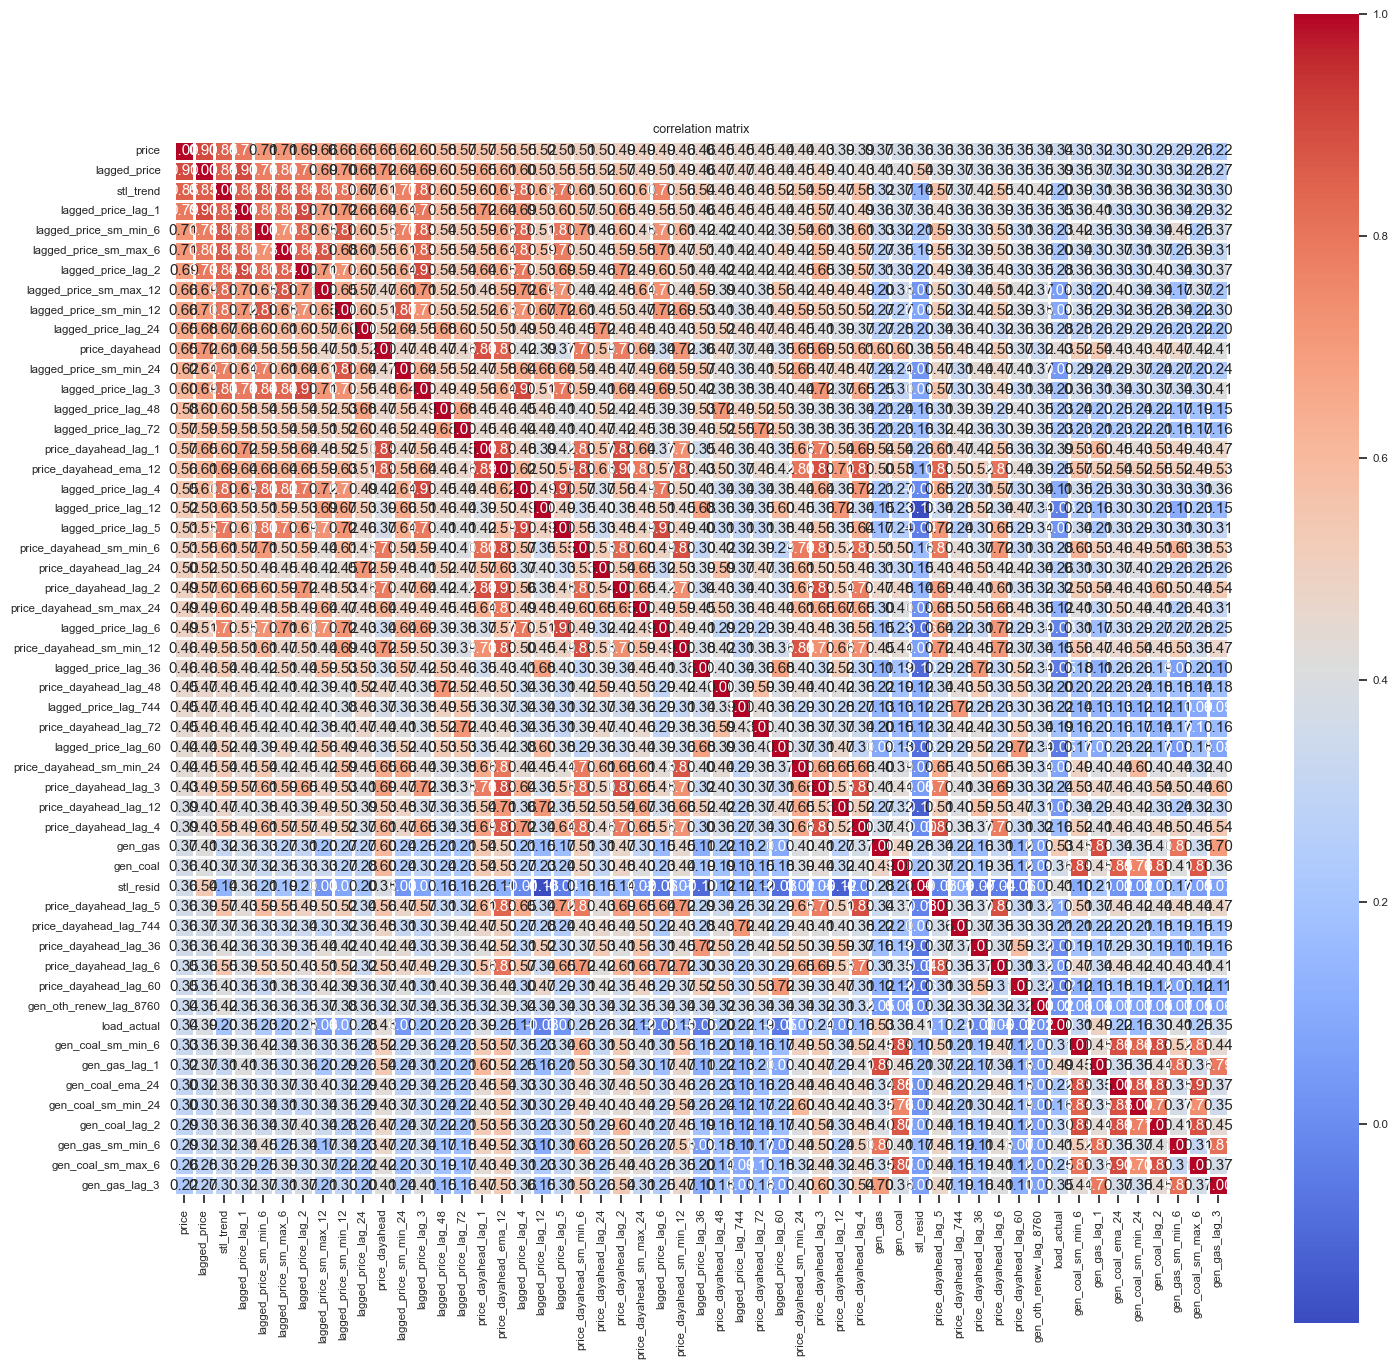

In [128]:
plt.figure(figsize = (17,17))
sns.set(font_scale=0.75)
ax = sns.heatmap(
    df_corr, 
    annot=True, 
    square=True, 
    linewidths=.75, cmap="coolwarm", 
    fmt = ".2f", 
    annot_kws = {"size": 11}
)
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

# Modeling

### Hyperparameter Tunning & Model Selection

In [129]:
train_periods = int(y.shape[0] * 0.8)
test_periods = int(y.shape[0] * 0.2)

X_train, X_test = X_stand.iloc[:train_periods], X_stand.iloc[train_periods:train_periods+test_periods]
y_train, y_test = y.iloc[:train_periods], y.iloc[train_periods:train_periods+test_periods]
X_forecast = X_stand.iloc[train_periods+test_periods:]

In [130]:
X_train.shape, X_test.shape

((28051, 52), (7012, 52))

In [131]:
y_train.shape, y_test.shape

((28051,), (7012,))

In [132]:
# Save X_test
write_to_s3(
    asset=X_test,
    path=f"{BUCKET}/datasets/X_test.csv"
)

In [133]:
# Define the search space
algorithms = [
    # 'expo_smooth', 
    # 'sarimax',     
    'random_forest',
    'lightgbm',
    # 'lstm',
]

int_parameters = [
    # expo_smooth
    'seasonal_periods',
    
    # sarimax
    'p', 'd', 'q',    
    'seasonal_P',
    'seasonal_D',
    'seasonal_Q',
    'seasonal_S',
    
    # random_forest
    'random_forest.n_estimators',
    'random_forest.max_depth',
    'random_forest.min_samples_split',
    
    # lightgbm
    'lightgbm.n_estimators',
    'lightgbm.max_depth',
    'lightgbm.min_child_samples',
    'num_leaves',
    
    # lstm
    'layers',
    'units',
    'batch_size',
]

choice_parameters = {
    # expo_smooth
    "expo_smooth.trend": ['additive', 'multiplicative', None],
    "damped_trend": [True, False],
    "seasonal": ['additive', 'multiplicative', None],
    "seasonal_periods": [12, 24, 24*7, 24*30],
    
    # sarimax
    "sarimax.trend": [None, 'ct'],
    "seasonal_S": [12, 24], # , 24*7, 24*30],
    
    # random_forest
    "random_forest.max_features": [1.0, 'sqrt'],
    
    # lightgbm
    "boosting_type": ['gbdt', 'dart'],
    
    # lstm
    "topology": ['classic', 'bidirectional', 'convolutional'],
    "units": [16, 32, 64, 128, 256],
    "batch_size": [16, 32, 64, 128, 256]
}

model_type_choices = [
    # Exponential Smoothing Search Space
#     {
#         "algorithm": 'expo_smooth',
#         "expo_smooth.trend": hp.choice('expo_smooth.trend', choice_parameters['expo_smooth.trend']),
#         "damped_trend": hp.choice('damped_trend', choice_parameters['damped_trend']),
#         "seasonal": hp.choice('seasonal', choice_parameters['seasonal']),
#         "seasonal_periods": scope.int(hp.choice('seasonal_periods', choice_parameters['seasonal_periods']))
#     },
    
    # SARIMAX Search Space
#     {
#         "algorithm": 'sarimax',
#         "sarimax.trend": hp.choice('sarimax.trend', choice_parameters['sarimax.trend']),
#         "p": scope.int(hp.quniform('p', 0, 6, 1)),
#         # "d": scope.int(hp.quniform('d', 0, 1, 1)),
#         "q": scope.int(hp.quniform('q', 0, 3, 1)),
#         "seasonal_P": scope.int(hp.quniform('seasonal_P', 0, 3, 1)),
#         # "seasonal_D": scope.int(hp.quniform('seasonal_D', 0, 1, 1)),
#         "seasonal_Q": scope.int(hp.quniform('seasonal_Q', 0, 2, 1)),
#         "seasonal_S": scope.int(hp.choice('seasonal_S', choice_parameters['seasonal_S']))
#     },
    
    # Random Forest Search Space
    {
        "algorithm": 'random_forest',
        "random_forest.n_estimators": scope.int(hp.quniform('random_forest.n_estimators', 5, 200, 1)),
        "random_forest.max_depth": scope.int(hp.quniform('random_forest.max_depth', 1, 100, 1)),
        "random_forest.min_samples_split": scope.int(hp.quniform('random_forest.min_samples_split', 5, 100, 1)),
        "random_forest.max_features": hp.choice('random_forest.max_features', choice_parameters['random_forest.max_features']),
    },
    
    # LightGBM Search Space
    {
        "algorithm": 'lightgbm',
        "boosting_type": hp.choice('boosting_type', choice_parameters['boosting_type']),
        "lightgbm.n_estimators": scope.int(hp.quniform('lightgbm.n_estimators', 5, 350, 1)),
        "lightgbm.max_depth": scope.int(hp.quniform('lightgbm.max_depth', 1, 175, 1)),
        "lightgbm.min_child_samples": scope.int(hp.quniform('lightgbm.min_child_samples', 5, 100, 1)),
        "lightgbm.learning_rate": hp.loguniform('lightgbm.learning_rate', np.log(0.001), np.log(0.3)),
        "num_leaves": scope.int(hp.quniform('num_leaves', 5, 150, 1)),        
        "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1)
    },
    
    # LSTM Search Space
    # {
    #     "algorithm": 'lstm',
    #     # "topology": hp.choice('topology', choice_parameters['topology']),
    #     "layers": scope.int(hp.quniform('layers', 1, 10, 1)), 
    #     "units": scope.int(hp.choice('units', choice_parameters['units'])),
    #     "dropout": hp.uniform('dropout', 0.0, 0.5),
    #     "recurrent_dropout": hp.uniform('recurrent_dropout', 0.0, 0.5),
    #     "lstm.learning_rate": hp.loguniform('lstm.learning_rate', np.log(0.001), np.log(0.1)),
    #     # "batch_size": scope.int(hp.choice('batch_size', choice_parameters['batch_size'])),
    # },
]

search_space = {
    "model_type": hp.choice('model_type', model_type_choices)
}

In [134]:
def fix_params(params: dict):
    # SARIMAX
    if params['model_type']['algorithm'] == 'sarimax':
        if 'd' not in params['model_type']:
            params['model_type']['d'] = 0
            
        if 'seasonal_D' not in params['model_type']:
            params['model_type']['seasonal_D'] = 0
            
        if params['model_type']['seasonal_P'] == params['model_type']['seasonal_Q'] == 0:
            params['model_type']['seasonal_S'] = 0
            
        if params['model_type']['q'] == params['model_type']['seasonal_Q']:
            if params['model_type']['q'] > 0:
                params['model_type']['q'] += 1
                
        if params['model_type']['p'] == params['model_type']['seasonal_P']:
            params['model_type']['p'] += 1
    
    # Exponential Smoothing
    if params['model_type']['algorithm'] == 'expo_smooth':
        if params['model_type']['expo_smooth.trend'] is None:
            params['model_type']['damped_trend'] = False
            
    return params


def find_trials():
    def extract_param_idx(name, value):
        if name in choice_parameters:
            return choice_parameters[name].index(value)
        return value
    
    def find_trials_dict(champion: bool = True):        
        # Load Champion
        model = Model()
        model.load(champion=champion)

        # Define dict
        trials_dict = {
            'model_type': algorithms.index(model.algorithm)
        }
        trials_dict.update({
            k: extract_param_idx(k, v) for k, v in model.hyper_parameters.items()
        })
        
        return trials_dict
    
    trials_list = [find_trials_dict(champ) for champ in [True, False]]
    
    return generate_trials_to_calculate(trials_list)


def objective(
    params: dict,
    selected_features: list
):
    trials.append(params)
    # try:
    # Extract algorithm
    algorithm = params['model_type']['algorithm']

    # Fix params
    params = fix_params(params)

    # Extract Hyper Parameters
    hyper_parameters = {
        k: v for k, v in params['model_type'].items() if k != 'algorithm'
    }

    ts_split = TimeSeriesSplit(n_splits=3, test_size=test_periods)

    scores = []

    for train_idx, val_idx in ts_split.split(X_train):
        # Split Features
        train_features = X_train.iloc[train_idx]
        val_features = X_train.iloc[val_idx]

        # Split Target
        train_target = y_train.iloc[train_idx]
        val_target = y_train.iloc[val_idx]

        # Instanciate the Model
        model = Model(
            algorithm=algorithm,
            hyper_parameters=hyper_parameters,
            selected_features=selected_features
        )

        # Build the model
        model.build(
            train_target=train_target.copy(), 
            train_features=train_features.copy()
        )

        # Fit the model
        model.fit(
            train_target=train_target.copy(), 
            train_features=train_features.copy()
        )

        # Predict the Validation Dataset
        val_pred = model.predict(
            forecast_features=val_features.copy(), 
            forecast_dates=val_features.index
        )

        scores.append(mean_absolute_percentage_error(val_target, val_pred))

    return {'loss': np.mean(scores), 'status': STATUS_OK}
#     except Exception as e:
#         logger.warning(f"Unable to run {params}.\n"
#                        f"Exception {e}")
#         return {'loss': np.inf, 'status': STATUS_OK}

In [135]:
# find_trials()

In [136]:
trials = []

fmin_objective = partial(
    objective,
    selected_features=selected_features
)

result = fmin(
    fn=fmin_objective,
    space=search_space,
    algo=tpe.suggest,
    # trials=find_trials(),
    max_evals=300,
    timeout=10 * 60, # 5 mins
    verbose=True,
    show_progressbar=True,
    early_stop_fn=None
)

 42%|████▏     | 127/300 [10:03<13:42,  4.75s/trial, best loss: 0.05278587179102881]


In [137]:
result

{'boosting_type': 0,
 'colsample_bytree': 0.9438275588196731,
 'lightgbm.learning_rate': 0.016316693732592487,
 'lightgbm.max_depth': 95.0,
 'lightgbm.min_child_samples': 28.0,
 'lightgbm.n_estimators': 282.0,
 'model_type': 1,
 'num_leaves': 97.0}

In [138]:
algos = [t['model_type']['algorithm'] for t in trials]
counts = Counter(algos)

for algo, reps in counts.items():
    logger.info(f"{algo}: {round(reps * 100 / len(algos), 1)} %")

### Model Evaluation

In [139]:
# Instanciate the "challenger" model

In [140]:
def extract_challenger(results: dict):
    def extract_parameter(k, v):
        if k in choice_parameters:
            v = choice_parameters[k][v]
        if k in int_parameters:
            v = int(v)
        return v
    
    # Extract algorithm
    algorithm = algorithms[results['model_type']]
    
    # Extract hyper parameters
    hyper_parameters = {
        k: extract_parameter(k, v) for k, v in results.items() if k not in ['algorithm', 'model_type']
    }
    
    return Model(
        algorithm=algorithm,
        hyper_parameters=hyper_parameters,
        selected_features=selected_features
    )

In [141]:
challenger = extract_challenger(result)

In [142]:
challenger

In [143]:
# Build & Re-fit model
challenger.build(
    train_target=y_train, 
    train_features=X_train
)

challenger.fit(
    train_target=y_train, 
    train_features=X_train
)

In [144]:
# Save Challenger
challenger.save(as_champion=False)

In [145]:
# Forecast Test Data
test_pred = challenger.predict(
    forecast_features=X_test, 
    forecast_dates=X_test.index
)

In [146]:
# Evaluate Performance (on unseen data)

In [147]:
challenger_mape = mean_absolute_percentage_error(y_test, test_pred)

In [148]:
challenger_mape

0.02899603846922476

### Champion Update

In [149]:
# Load Champion
champion = Model()
champion.load(champion=True)

# Fit champion
champion.fit(
    train_target=y_train, 
    train_features=X_train
)

# Forecast test data
test_pred = champion.predict(
    forecast_features=X_test, 
    forecast_dates=X_test.index
)

# Evaluate champion
champion_mape = mean_absolute_percentage_error(y_test, test_pred)

logger.info(f'champion_mape: {round(champion_mape*100, 2)} %\n'
            f'challenger_mape: {round(challenger_mape*100, 2)} %\n')

if challenger_mape < champion_mape:
    challenger.save(as_champion=True)

In [150]:
print(f"Model objective: {champion.model.get_params()['objective']}")

KeyError: 'objective'